In [250]:
!pip install scipy

In [251]:
!pip install scikit-posthocs


  Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)


# Importa√ß√£o de Pacotes e modulos

In [1]:
import mlflow

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import networkx as nx

In [232]:
from pathlib import Path
from sklearn.preprocessing import StandardScaler,RobustScaler, LabelEncoder,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [5]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    v_measure_score,
    normalized_mutual_info_score,
    fowlkes_mallows_score
)

In [6]:
from loguru import logger

In [7]:
from sklearn.metrics import accuracy_score, classification_report

In [8]:
from sklearn.neighbors import kneighbors_graph

In [9]:
PROJ_ROOT = Path('__file__').resolve().parents[1]
logger.info(f"PROJ_ROOT path is: {PROJ_ROOT}")

2025-06-11 11:51:59.748 | INFO     | __main__:<module>:2 - PROJ_ROOT path is: /home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/clustering_uff_ml


In [11]:
# Define logs directory
LOGS_DIR = PROJ_ROOT/"logs"
LOGS_DIR.mkdir(exist_ok=True)  

print("caminhodo projeto ->  ",LOGS_DIR)


caminhodo projeto ->   /home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/clustering_uff_ml/logs


In [12]:
# Configure loguru to save logs to a file
logger.remove()  # Remove default console handler
logger.add(
    LOGS_DIR / "clustering.log",
    rotation="10 MB",  # Rotate log file when it reaches 10 MB
    retention="10 days",  # Keep logs for 10 days
    level="INFO",
    format="{time:YYYY-MM-DD HH:mm:ss} | {level} | {message}"
)


1

# KDD 1 Sele√ß√£o


In [13]:
path = '../data/raw/iris/iris.data'

## Identifica√ß√£o de Dados

In [14]:
def carregaDataset(path,nameColumns="") -> pd.DataFrame:
    try:
        if name_columns!="":
            return pd.read_csv(path,header=None,names=name_columns)
        return pd.read_csv(path)
    except Exception as e:
        logger.error(f"Problema ao carregar o dataset - {path}")

In [15]:
name_columns = ['sepal_lenght','sepal_width','petal_lenght','petal_width','target']

In [16]:
ds = carregaDataset(path,name_columns)

In [17]:
ds.head()

sepal_lenght  sepal_width  petal_lenght  petal_width       target
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

In [18]:
ds.describe()

sepal_lenght  sepal_width  petal_lenght  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

## Caracteriza√ß√£o dos dados

In [19]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_lenght  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_lenght  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Defini√ß√£o do subconjunto 

Ser√° utilizado todo o dataset pois este dataset j√° est√° pronto balanceado e n√£o possui dados ausentes

In [20]:
X = ds.drop('target', axis=1)
y_true = ds['target']

# KDD 2 Pr√©-processamento
Como os algoritmos de clustering s√£o baseados em dist√¢ncia, precisamos garantir que todas as features estejam na mesma escala.

In [21]:
def scaleData(X,metodo='standard'):
    try:
        if metodo == 'standard':
            scaler = StandardScaler()
        elif metodo == "robust":
            scaler =RobustScaler()
        else: 
            raise ValueError("M√©todo inv√°lido: use 'standard ou robust'")
            
        logger.success(f"realizada scalonamento do dataset com {metodo}")
        return scaler.fit_transform(X)
        
    except Exception as e:
        logger.error(f'{e} | LOCAL: fun√ß√£o scaleData()')
           

In [114]:
def plot_pairplot(ds,titulo=None):
    sns.set_theme(style="ticks")
    
    # hue='target': diz ao seaborn para colorir os pontos com base na coluna 'target' que cont√©m as especies
    # diag_kind='kde': mostra uma estimativa de densidade na diagonal em vez de um histograma
    # markers: usa marcadores diferentes para cada esp√©cie, melhorando a acessibilidade
    sns.pairplot(
        ds, 
        hue='target', 
        diag_kind='kde',
        markers=["o", "s", "D"],
        palette='viridis' # esquema de cores 
    )
    

    plt.suptitle(f"{titulo}", y=1.02, fontsize=16)    
    plt.show()


## An√°lise Visual discrimiante do dataset sem pr√©-processamento

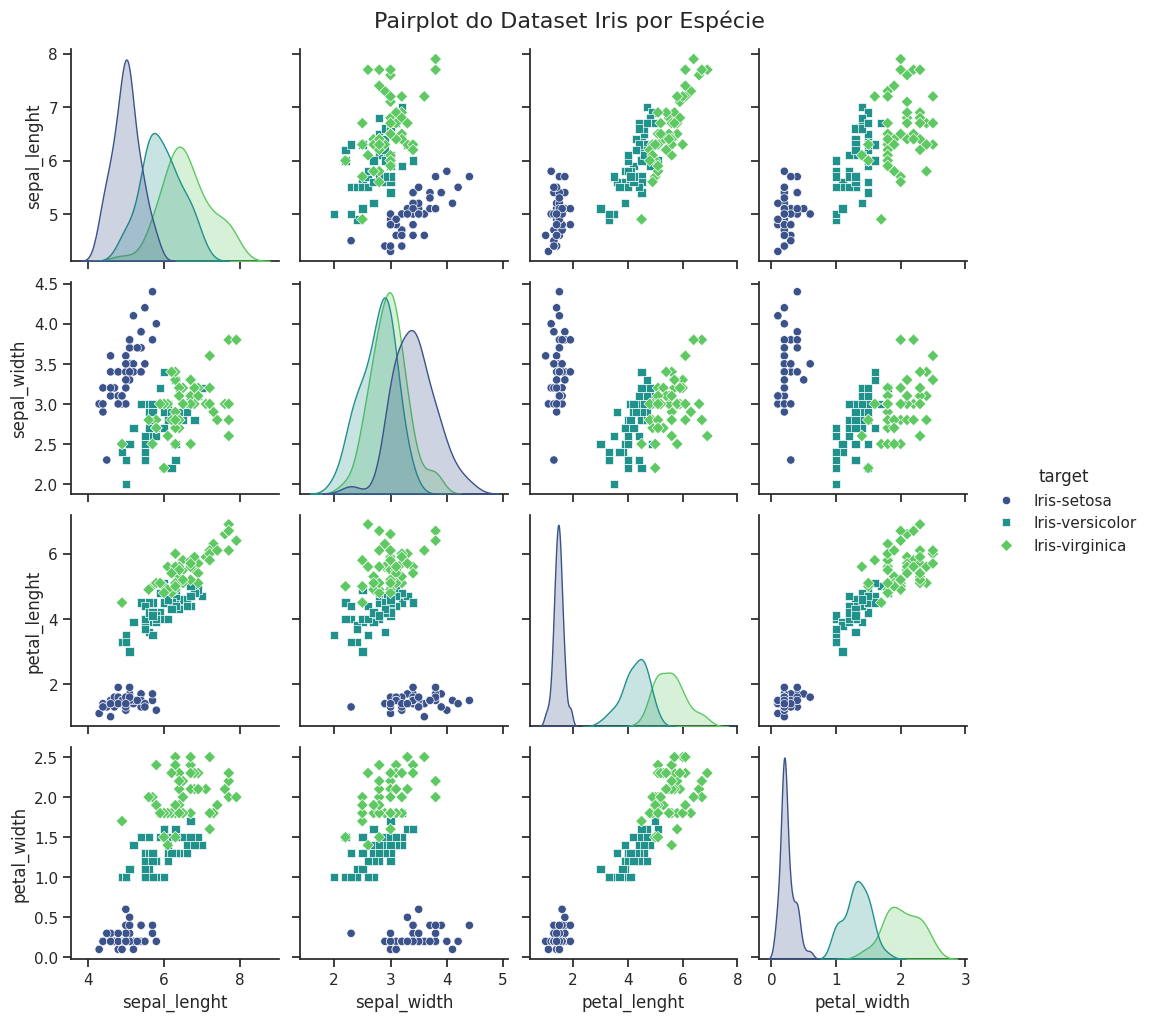

In [116]:
plot_pairplot(ds,"Pairplot do Dataset Iris por Esp√©cie")

## Limpeza de Dados 

Dados est√£o balanceados igualmente entre as 3 classes

### Remo√ß√£o de ruidos

#### An√°lise de Boxplot

In [22]:
X_scaled = scaleData(X,metodo='standard')

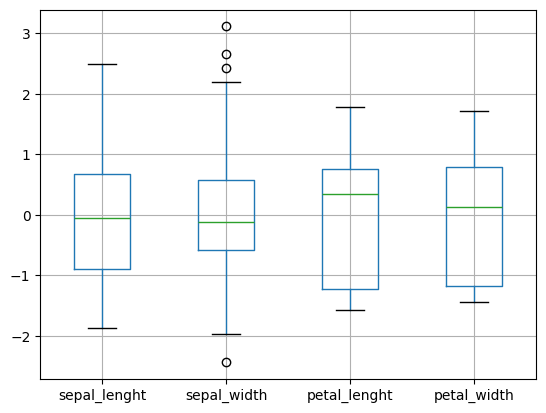

In [104]:
pd.DataFrame(X_scaled,columns=name_columns[:-1] ).boxplot()
plt.show()

In [95]:
X_robust = scaleData(X, metodo='robust')

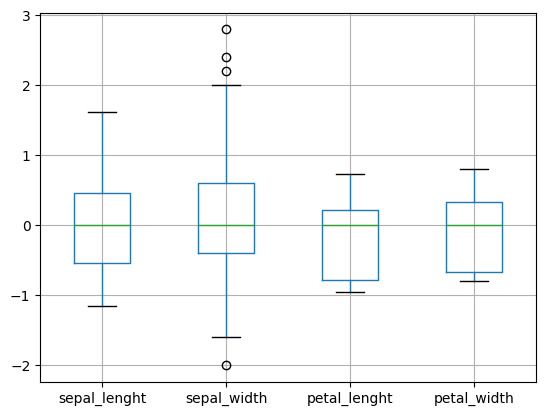

In [106]:
pd.DataFrame(X_robust,columns=name_columns[:-1]).boxplot()
plt.show()

A an√°lise de boxplot evid√™ncia que a √∫nica vari√°vel que possui outlier √© sepal_width ( vale ressaltare que ruido e outilier s√£o diferentes como de3scrito na se√ß√£o Ruido Vs Outlier do artigo
https://www.sciencedirect.com/science/article/abs/pii/S1574013720304068 

### Tratamento de valores Ausentes

Sem valores faltamtes ou nulos

In [27]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_lenght  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_lenght  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


### Deduplica√ß√£o

In [28]:
ds[ds.duplicated(keep=False)]

sepal_lenght  sepal_width  petal_lenght  petal_width          target
9             4.9          3.1           1.5          0.1     Iris-setosa
34            4.9          3.1           1.5          0.1     Iris-setosa
37            4.9          3.1           1.5          0.1     Iris-setosa
101           5.8          2.7           5.1          1.9  Iris-virginica
142           5.8          2.7           5.1          1.9  Iris-virginica

Os registros 9,34,37,101,142 est√£o repetidos

In [32]:
ds_deduplicado = ds.drop_duplicates(keep='first', inplace=False)

In [33]:
ds_deduplicado 

sepal_lenght  sepal_width  petal_lenght  petal_width          target
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[147 rows x 5 columns]

In [99]:
ds.to_csv('../data/interim/001-apcb-deduplicado.csv')

### Tratamento da vari√°vel Target categ√≥rica

## Normaliza√ß√£o/Escalonamento

In [35]:
lb =LabelEncoder()
lb.fit_transform(ds_deduplicado.target)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [37]:
y_true_lb = lb.fit_transform(ds_deduplicado.target)

In [38]:
ds_deduplicado_lb = ds_deduplicado.copy()
ds_deduplicado_lb['target'] =  y_true_lb

In [39]:
ds_deduplicado_lb.to_csv('../data/interim/001-apcb-deduplicado_lb.csv')

# KDD 3 Transforma√ß√£o

## Redu√ß√£o de dimensionalidade 

## Engenharia de Features

## An√°lise Explorat√≥ria

In [40]:
def reducaoDimensao(X, n_componentes=3, feature_names=None):
    """
    Realiza a redu√ß√£o de dimensionalidade utilizando PCA.

    Args:
        X (np.array ou pd.DataFrame): O conjunto de dados de entrada (espera-se que j√° esteja padronizado se voc√™ o chama com X_scaled).
                                     Se X for um pandas DataFrame, seu √≠ndice ser√° usado; caso contr√°rio, um √≠ndice padr√£o ser√° criado.
        n_componentes (int): O n√∫mero de componentes principais a serem mantidos.
        feature_names (list, optional): Uma lista de strings com os nomes das features originais.
                                        Essencial para rotular corretamente os loadings.
                                        Se None e X for um DataFrame, X.columns ser√° usado.
                                        Se None e X for um array NumPy, ser√£o gerados nomes gen√©ricos (feature_1, feature_2...).

    Returns:
        tuple:
            - pd.DataFrame: O dataset transformado com a dimensionalidade reduzida.
            - pd.DataFrame: DataFrame com a vari√¢ncia explicada por cada componente e acumulada,
                            e a relev√¢ncia (loadings) de cada feature para cada componente.
                            As linhas representam os componentes e as colunas representam as features.
    """
    try:
        X_processed = X

        # Determinar os nomes das features se n√£o forem fornecidos explicitamente
        if feature_names is None:
            if isinstance(X, pd.DataFrame):
                feature_names = X.columns.tolist()
            else: # X √© um array NumPy
                feature_names = [f'feature_{i+1}' for i in range(X.shape[1])]


        pca = PCA(n_components=n_componentes)
        X_pca_array = pca.fit_transform(X_processed)

        # Cria o DataFrame X_pca
        colunas_pca = [f'Componente_{i+1}' for i in range(X_pca_array.shape[1])]
        if hasattr(X, 'index') and isinstance(X, pd.DataFrame):
            X_pca = pd.DataFrame(X_pca_array, columns=colunas_pca, index=X.index)
        else:
            X_pca = pd.DataFrame(X_pca_array, columns=colunas_pca)


 
        # Cria um DataFrame para os loadings
        # pca.components_ tem o formato (n_components, n_features)
        # As colunas ser√£o os nomes das features, e o √≠ndice ser√£o os nomes dos componentes (PC1, PC2, etc.)
        loadings_df = pd.DataFrame(pca.components_,
                                   columns=feature_names,
                                   index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])

        # Criar o DataFrame de vari√¢ncia explicada e acumulada
        df_variance_data = {
            'Variancia_Explicada': pca.explained_variance_ratio_,
            'Variancia_Acumulada': pca.explained_variance_ratio_.cumsum()
        }
        # O √≠ndice deste DataFrame tamb√©m ser√£o os nomes dos componentes para facilitar a concatena√ß√£o
        df_variance = pd.DataFrame(df_variance_data,
                                   index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])

        # Concatenar os DataFrames de vari√¢ncia e loadings horizontalmente (pelas colunas)
        # O resultado ser√° df_pca_var com colunas de vari√¢ncia e colunas de loadings para cada feature
        df_pca_var = pd.concat([df_variance, loadings_df], axis=1)


        logger.success("Redu√ß√£o de dimensionalidade realizada!")
        return X_pca, df_pca_var
    except Exception as e:
        logger.error(f"Problema na redu√ß√£o de dimensionalidade: {e}")
        return None, None # Retorna None para ambos em caso de erro

In [41]:
def cluster(X, metodo, numero_cluster=3):
    if metodo == 'kmeans':
        modelo = KMeans(n_clusters=numero_cluster,random_state=42)

    elif metodo =='hcluster':
        modelo = AgglomerativeClustering(n_clusters=numero_cluster)
    
    else: raise ValueError("M√©todo inv√°lido: use 'kmeans ou hcluster'")
    labels = modelo.fit_transform(X)
    return labels, modelo

In [277]:
def plot_scatter(X,Y,hue=None,xlabel='',ylabel='',titulo='',legenda='',paletaCores=None,tamanhoPonto=100,transparencia=0.5):
    sns.scatterplot(
        x=X, 
        y=Y, 
        hue=hue,  # A 'm√°gica' acontece aqui: colorir pela vari√°vel de grupo
        palette=paletaCores, # Fornecendo as cores exatas que voc√™ quer
        s=tamanhoPonto,              # Tamanho dos pontos
        alpha=transparencia,          # Transpar√™ncia
        legend='full'if legenda!='' else None
    )
    if titulo:
        plt.title(f'{titulo}')
    else:   
        plt.title('Clusters Visualizados com PCA com colora√ß√£o por Target')
    plt.xlabel('Primeiro Componente Principal')
    plt.ylabel('Segundo Componente Principal')
    plt.legend(title='Cluster ID')
    plt.show()

### Usando PCA na EDA para avaliar o qu√£o bem o dataset √© agrupado por dois componentes 

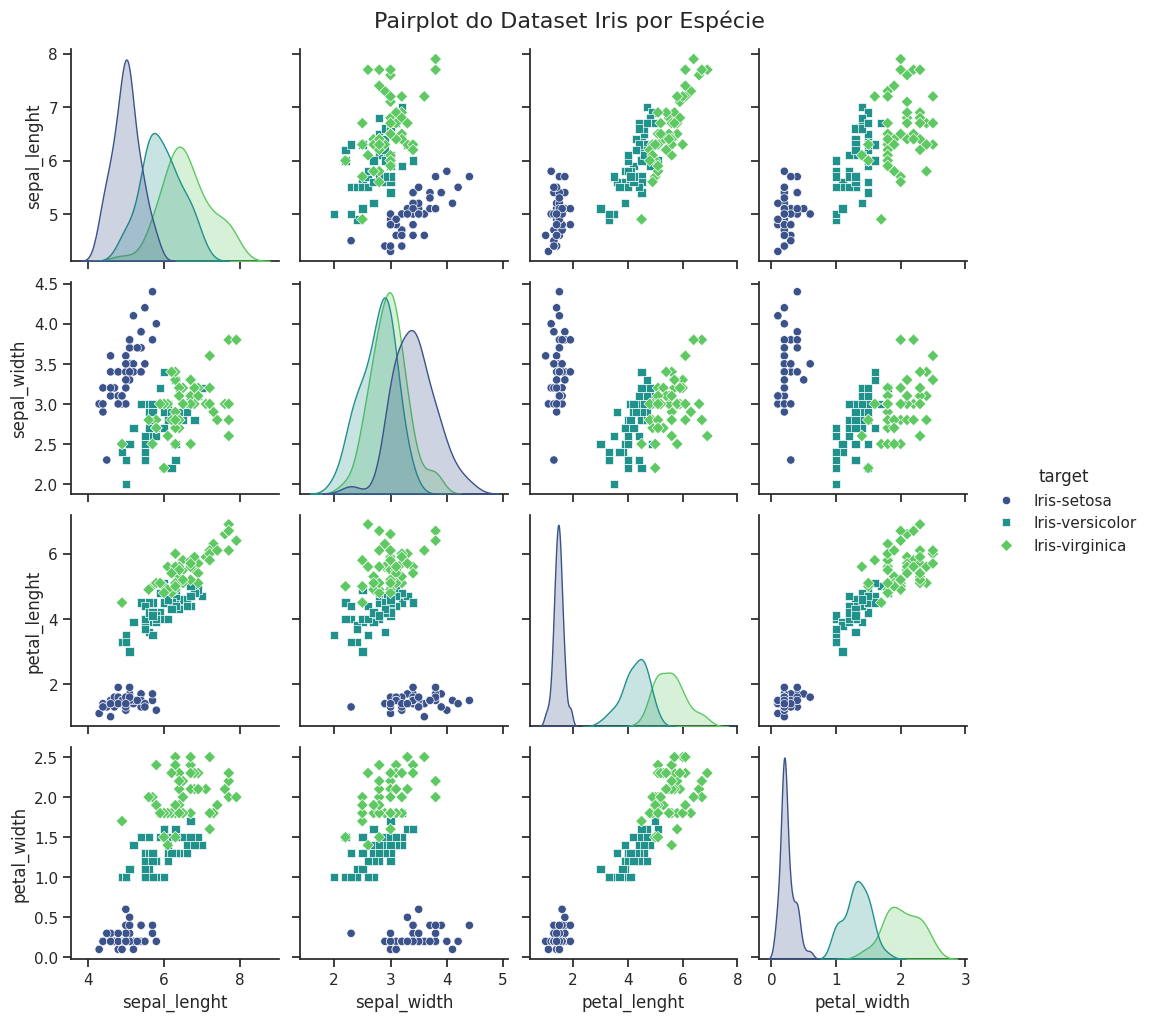

In [115]:
plot_pairplot(ds,"Pairplot do Dataset Iris por Esp√©cie")

In [55]:
list(ds.columns)

['sepal_lenght', 'sepal_width', 'petal_lenght', 'petal_width', 'target']

In [82]:
X_pca,df_pca_var = reducaoDimensao(X=X_scaled, n_componentes=3) 

In [83]:
X_pca

Componente_1  Componente_2  Componente_3
0       -2.264542      0.505704      0.121943
1       -2.086426     -0.655405      0.227251
2       -2.367950     -0.318477     -0.051480
3       -2.304197     -0.575368     -0.098860
4       -2.388777      0.674767     -0.021428
..            ...           ...           ...
145      1.870522      0.382822     -0.254532
146      1.558492     -0.905314      0.025382
147      1.520845      0.266795     -0.179277
148      1.376391      1.016362     -0.931405
149      0.959299     -0.022284     -0.528794

[150 rows x 3 columns]

In [84]:
X_pca.head()

Componente_1  Componente_2  Componente_3
0     -2.264542      0.505704      0.121943
1     -2.086426     -0.655405      0.227251
2     -2.367950     -0.318477     -0.051480
3     -2.304197     -0.575368     -0.098860
4     -2.388777      0.674767     -0.021428

In [85]:
df_pca_var.head()

Variancia_Explicada  Variancia_Acumulada  feature_1  feature_2  \
PC1             0.727705             0.727705   0.522372  -0.263355   
PC2             0.230305             0.958010   0.372318   0.925556   
PC3             0.036838             0.994848   0.721017  -0.242033   

     feature_3  feature_4  
PC1   0.581254   0.565611  
PC2   0.021095   0.065416  
PC3  -0.140892  -0.633801

In [86]:
list(zip(list(ds.columns)[:-1], list(df_pca_var.columns)[2:]))


[('sepal_lenght', 'feature_1'),
 ('sepal_width', 'feature_2'),
 ('petal_lenght', 'feature_3'),
 ('petal_width', 'feature_4')]

In [87]:
df_pca_var

Variancia_Explicada  Variancia_Acumulada  feature_1  feature_2  \
PC1             0.727705             0.727705   0.522372  -0.263355   
PC2             0.230305             0.958010   0.372318   0.925556   
PC3             0.036838             0.994848   0.721017  -0.242033   

     feature_3  feature_4  
PC1   0.581254   0.565611  
PC2   0.021095   0.065416  
PC3  -0.140892  -0.633801

In [107]:
X_pca_robust,df_pca_var_robust = reducaoDimensao(X=X_robust,n_componentes=3)

In [108]:
df_pca_var_robust

Variancia_Explicada  Variancia_Acumulada  feature_1  feature_2  \
PC1             0.615788             0.615788  -0.447657   0.641472   
PC2             0.351235             0.967022   0.548645   0.746909   
PC3             0.029714             0.996736   0.676170  -0.159989   

     feature_3  feature_4  
PC1  -0.450984  -0.429802  
PC2   0.254204   0.276580  
PC3  -0.259558  -0.670691

/tmp/ipykernel_20934/3354970667.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


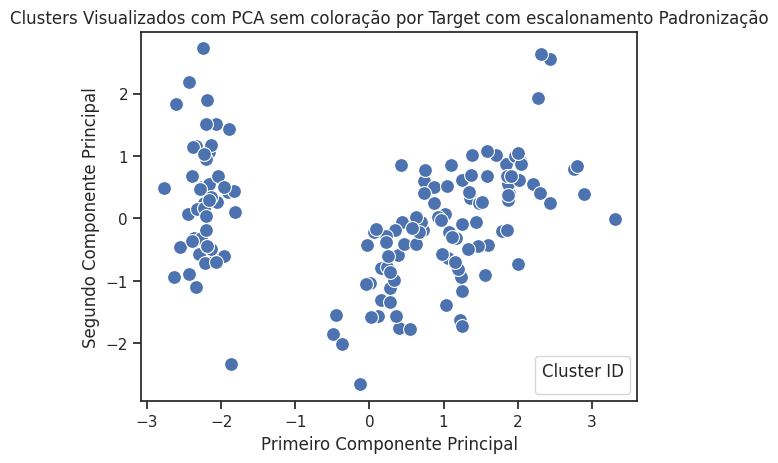

In [278]:
plot_scatter(X=X_pca['Componente_1'],
             Y=X_pca['Componente_2'],
             titulo='Clusters Visualizados com PCA sem colora√ß√£o por Target com escalonamento Padroniza√ß√£o',
             xlabel='Primeiro Componente Principal',
             ylabel='Segundo Componente Principal',
             transparencia=1
            )

/tmp/ipykernel_20934/3354970667.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


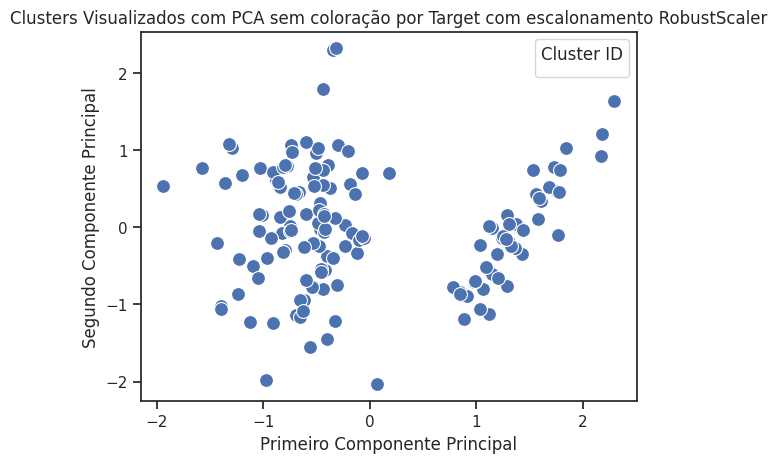

In [279]:
plot_scatter(X=X_pca_robust['Componente_1'],
             Y=X_pca_robust['Componente_2'],
             titulo='Clusters Visualizados com PCA sem colora√ß√£o por Target com escalonamento RobustScaler',
             xlabel='Primeiro Componente Principal',
             ylabel='Segundo Componente Principal',
             transparencia=1
            )

/tmp/ipykernel_20934/3354970667.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


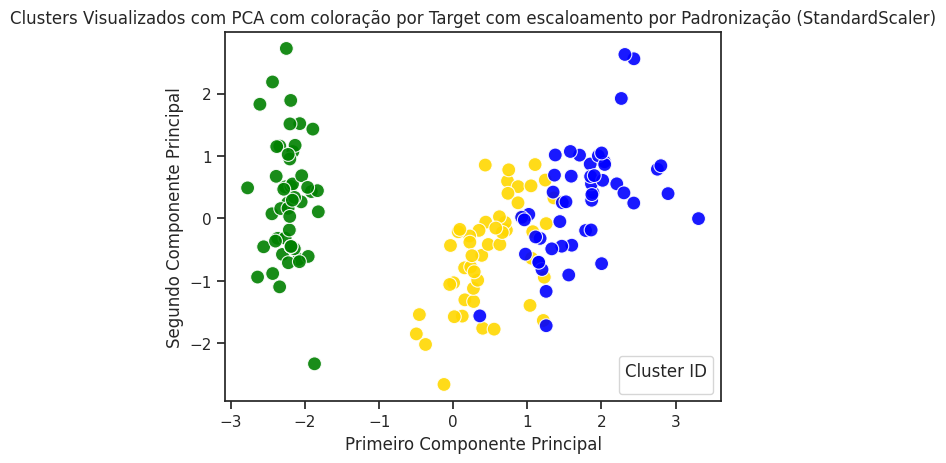

In [280]:
plot_scatter(X=X_pca['Componente_1'],
             Y=X_pca['Componente_2'],
             hue=y_true, 
             paletaCores=['green', 'gold', 'blue'],
             tamanhoPonto=100, 
             transparencia=0.9, 
             titulo='Clusters Visualizados com PCA com colora√ß√£o por Target com escaloamento por Padroniza√ß√£o (StandardScaler)',
             xlabel='Primeiro Componente Principal',
             ylabel='Segundo Componente Principal',
             
            )

/tmp/ipykernel_20934/3354970667.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


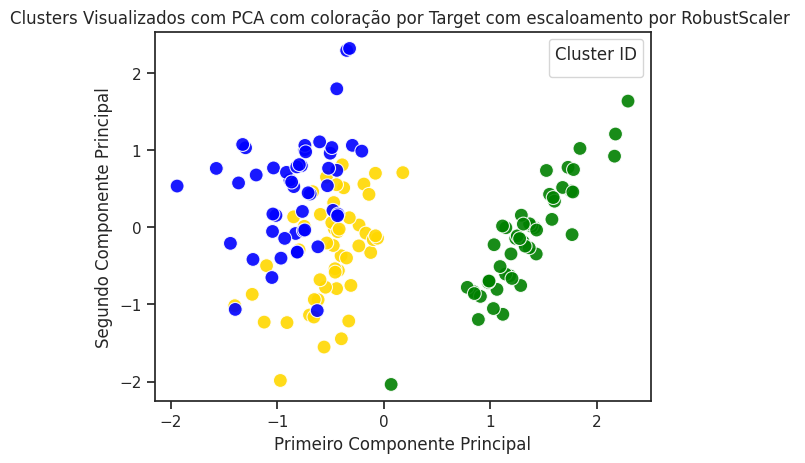

In [281]:
plot_scatter(X=X_pca_robust['Componente_1'],
             Y=X_pca_robust['Componente_2'],
             hue=y_true, 
             paletaCores=['green', 'gold', 'blue'],
             tamanhoPonto=100, 
             transparencia=0.9, 
             titulo='Clusters Visualizados com PCA com colora√ß√£o por Target com escaloamento por RobustScaler ',
             xlabel='Primeiro Componente Principal',
             ylabel='Segundo Componente Principal',
             
            )

### PAIRPLOT

# KDD 4 Minera√ß√£o  de Dados

## Escolha de modelo(s) 

In [121]:
def run_single_cluster(X_scaled, k, algorithm='kmeans', linkage='ward'):
    """
    Executa um algoritmo de clustering uma vez para um k espec√≠fico.

    Args:
        X_scaled (np.ndarray): Dados padronizados.
        k (int): O n√∫mero de clusters para formar.
        algorithm (str): 'kmeans' ou 'hcluster'.
        linkage (str): M√©todo de linkage para hcluster.

    Returns:
        tuple: Uma tupla contendo (labels, inertia, model).
               'inertia' ser√° np.nan para hcluster.
    """
    if algorithm == 'kmeans':
        model = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = model.fit_predict(X_scaled)
        inertia = model.inertia_
    elif algorithm == 'hcluster':
        model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage=linkage)
        labels = model.fit_predict(X_scaled)
        inertia = np.nan  # hcluster n√£o tem o atributo 'inertia'
    else:
        raise ValueError("Algoritmo n√£o suportado. Escolha 'kmeans' ou 'hcluster'.")

    return labels, inertia, model

In [122]:
def evaluate_multiple_clusters(X_scaled, y_true, cluster_range, algorithm='kmeans', linkage='ward'):
    """
    Testa um algoritmo de clustering para um intervalo de 'k' e retorna as m√©tricas de avalia√ß√£o.

    Args:
        X_scaled (np.ndarray): Dados padronizados.
        y_true (pd.Series or np.ndarray): R√≥tulos verdadeiros.
        cluster_range (range or list): O intervalo de k's a testar (ex: range(2, 11)).
        algorithm (str): 'kmeans' ou 'hcluster'.
        linkage (str): M√©todo de linkage para hcluster.

    Returns:
        pd.DataFrame: Um DataFrame com todas as m√©tricas para cada valor de k.
    """
    metrics_list = []
    for k in cluster_range:
        # Usa a fun√ß√£o "motor" para obter os resultados para este 'k'
        labels, inertia, _ = run_single_cluster(X_scaled, k, algorithm, linkage)

        # Calcula todas as m√©tricas
        metrics = {
            'inertia': inertia,
            'silhouette': silhouette_score(X_scaled, labels),
            'davies_bouldin': davies_bouldin_score(X_scaled, labels),
            'calinski_harabasz': calinski_harabasz_score(X_scaled, labels),
            'ari': adjusted_rand_score(y_true, labels),
            'v_measure': v_measure_score(y_true, labels),
            'nmi': normalized_mutual_info_score(y_true, labels),
            'fowlkes_mallows': fowlkes_mallows_score(y_true, labels)
        }
        metrics_list.append(metrics)

    # O return est√° FORA do loop, retornando o resultado completo
    results_df = pd.DataFrame(metrics_list, index=cluster_range)
    results_df.index.name = 'k'
    return results_df

In [275]:
def plot_clustering_evaluation(results_df,titulo=None):
    """
    Plota as principais m√©tricas de avalia√ß√£o de clustering a partir de um DataFrame de resultados.

    Args:
        results_df (pd.DataFrame): DataFrame com 'k' como √≠ndice e m√©tricas nas colunas.
    """
    # Cria uma figura com 4 subplots (2 linhas, 2 colunas)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'An√°lise de Crit√©rios de Avalia√ß√£o de Cluster - {titulo}', fontsize=18, y=1.02)
    
    k_values = results_df.index
    
    # --- 1. Crit√©rio Relativo: M√©todo do Cotovelo (Inertia) ---
    ax1 = axes[0, 0]
    ax1.plot(k_values, results_df['inertia'], marker='o', linestyle='--')
    ax1.set_title(f'M√©todo do Cotovelo (Crit√©rio Relativo) para {titulo}', fontsize=14)
    ax1.set_xlabel('N√∫mero de Clusters (k)')
    ax1.set_ylabel('Inertia (WCSS) - Menor √© Melhor')
    ax1.grid(True)

    # --- 2. Crit√©rio Interno: Silhouette Score ---
    ax2 = axes[0, 1]
    ax2.plot(k_values, results_df['silhouette'], marker='o', linestyle='--', color='g')
    ax2.set_title(f'Silhouette Score (Crit√©rio Interno) - {titulo}', fontsize=14)
    ax2.set_xlabel('N√∫mero de Clusters (k)')
    ax2.set_ylabel('Silhouette Score - Maior √© Melhor')
    ax2.grid(True)
    
    # --- 3. Outros Crit√©rios Internos (ex: Davies-Bouldin) ---
    ax3 = axes[1, 0]
    ax3.plot(k_values, results_df['davies_bouldin'], marker='o', linestyle='--', color='r')
    ax3.set_title(f'Davies-Bouldin Score (Crit√©rio Interno) - {titulo}', fontsize=14)
    ax3.set_xlabel('N√∫mero de Clusters (k)')
    ax3.set_ylabel('Davies-Bouldin - Menor √© Melhor')
    ax3.grid(True)
    
    # --- 4. Crit√©rio Externo: Adjusted Rand Index (ARI) ---
    ax4 = axes[1, 1]
    ax4.plot(k_values, results_df['ari'], marker='o', linestyle='--', color='purple')
    ax4.set_title(f'Adjusted Rand Index (Crit√©rio Externo) - {titulo}', fontsize=14)
    ax4.set_xlabel('N√∫mero de Clusters (k)')
    ax4.set_ylabel('ARI - Maior √© Melhor')
    ax4.grid(True)
    
    # Ajusta o layout para evitar sobreposi√ß√£o de t√≠tulos
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()


### Kmeans

## Aplica√ß√£o de modelos

## Clustering com escaolmaneto por padroniza√ß√£o 

In [ ]:
# Definindo  o intervalo de k a ser testado
k_range_to_test = range(2, 11)

In [127]:
n_cluster = 3

### Com kmeans + StandardScaler

In [215]:
# Treinando o modelo final com o k escolhido para kmeans
final_k = n_cluster
final_labels, final_inertia, final_model = run_single_cluster(X_scaled, final_k, algorithm='kmeans')

print(f"\nModelo K-Means final treinado com k={final_k}")


Modelo K-Means final treinado com k=3


In [217]:
# Obtensdo a tabela de m√©tricas para o K-Means
kmeans_evaluation = evaluate_multiple_clusters(X_scaled, y_true, k_range_to_test, algorithm='kmeans')


In [218]:
print("--- Tabela de Avalia√ß√£o K-Means ---")
display(kmeans_evaluation)

--- Tabela de Avalia√ß√£o K-Means ---


inertia  silhouette  davies_bouldin  calinski_harabasz       ari  \
k                                                                         
2   223.732006    0.580184        0.597555         248.903428  0.568116   
3   192.037174    0.478724        0.786801         156.143038  0.428951   
4   114.682216    0.387247        0.865605         205.949969  0.493292   
5    91.295445    0.347265        0.940632         201.987516  0.437172   
6    81.760261    0.336223        0.990627         182.549618  0.478868   
7    80.982381    0.268562        1.121924         152.748286  0.388810   
8    68.086239    0.315682        1.080345         158.479169  0.380247   
9    59.385289    0.299142        1.068418         160.449405  0.295319   
10   52.989997    0.321103        1.015119         160.578315  0.311790   

    v_measure       nmi  fowlkes_mallows  
k                                         
2    0.733680  0.733680         0.771454  
3    0.587378  0.587378         0.661310  
4    0.609087  0.609087         0.647329  
5    0.590811  0.590811         0.596313  
6    0.633982  0.633982         0.628443  
7    0.567147  0.567147         0.554604  
8    0.535420  0.535420         0.548786  
9    0.524827  0.524827         0.474939  
10   0.545280  0.545280         0.493397

### Com HCluster + StandardScaler

In [126]:
# Obte√ß√£o da tabela de m√©tricas para o H-Cluster
hcluster_evaluation = evaluate_multiple_clusters(X_scaled, y_true, k_range_to_test, algorithm='hcluster')

print("\n--- Tabela de Avalia√ß√£o Agrupamento Hier√°rquico ---")
display(hcluster_evaluation)


--- Tabela de Avalia√ß√£o Agrupamento Hier√°rquico ---


inertia  silhouette  davies_bouldin  calinski_harabasz       ari  \
k                                                                      
2       NaN    0.575387        0.596309         237.825904  0.543752   
3       NaN    0.445540        0.805940         220.260437  0.615323   
4       NaN    0.399326        0.981081         198.730315  0.587941   
5       NaN    0.354970        0.946529         194.961557  0.469702   
6       NaN    0.337151        0.966654         174.391544  0.451442   
7       NaN    0.339329        0.950908         164.153757  0.412782   
8       NaN    0.339758        0.873925         158.121908  0.400524   
9       NaN    0.344525        0.928873         157.361733  0.401612   
10      NaN    0.327011        0.924879         161.610446  0.308865   

    v_measure       nmi  fowlkes_mallows  
k                                         
2    0.692454  0.692454         0.758044  
3    0.675470  0.675470         0.749782  
4    0.663414  0.663414         0.712677  
5    0.615921  0.615921         0.621856  
6    0.606291  0.606291         0.606878  
7    0.583427  0.583427         0.575751  
8    0.572516  0.572516         0.565730  
9    0.560638  0.560638         0.565476  
10   0.532077  0.532077         0.485772

In [197]:
# Treinando o modelo final com o k escolhido para HCluster
final_k_hc = n_cluster
final_labels_hc, final_inertia_hc, final_model_hc = run_single_cluster(X_scaled, final_k_hc, algorithm='hcluster')

print(f"\nModelo Hcluester final treinado {final_k_hc}")


Modelo Hcluester final treinado 3


/tmp/ipykernel_20934/3354970667.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


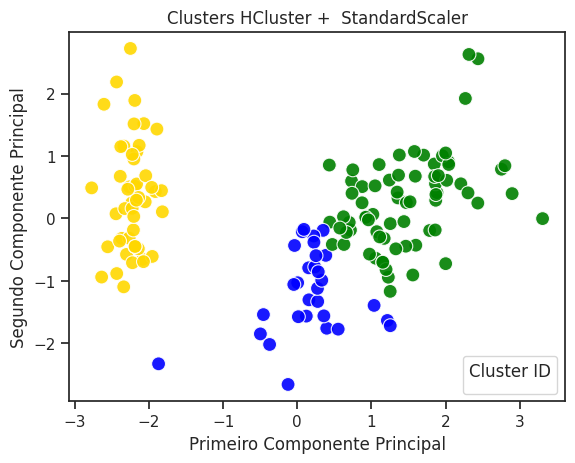

In [285]:
plot_scatter(X=X_pca['Componente_1'],
             Y=X_pca['Componente_2'],
             hue=final_labels_hc, 
             paletaCores=['green', 'gold', 'blue'],
             tamanhoPonto=100, 
             transparencia=0.9, 
             titulo='Clusters HCluster +  StandardScaler',
             xlabel='Primeiro Componente Principal',
             ylabel='Segundo Componente Principal',
             
            );

## treinando o modelo com o k mais com escalonamento pelo m√©todo RobustScaler

### KMeans + RobustScaler

In [144]:
final_k_robust = n_cluster
final_labels_robust, final_inertia_robust, final_model_robust = run_single_cluster(X_robust, final_k_robust, algorithm='kmeans')

print(f"\nModelo K-Means final treinado com K={final_k_robust} ")


Modelo K-Means final treinado com K=3 


In [164]:
kmeans_evaluation_robust = evaluate_multiple_clusters(X_robust, y_true, k_range_to_test, algorithm='kmeans')

In [212]:
display(kmeans_evaluation_robust)

inertia  silhouette  davies_bouldin  calinski_harabasz       ari  \
k                                                                         
2   115.197803    0.526149        0.715571         171.825148  0.543752   
3    73.583736    0.441845        0.833200         175.156947  0.571275   
4    65.261552    0.359243        1.044496         136.972364  0.532174   
5    48.511736    0.346435        0.967844         149.768562  0.412139   
6    43.227990    0.336336        0.922031         137.052695  0.324211   
7    33.397209    0.358558        0.920653         153.818505  0.276858   
8    29.664622    0.347918        0.986071         149.948393  0.295910   
9    24.320266    0.382589        0.830834         162.783043  0.284137   
10   22.381629    0.365446        0.907263         157.461500  0.292906   

    v_measure       nmi  fowlkes_mallows  
k                                         
2    0.692454  0.692454         0.758044  
3    0.610350  0.610350         0.712284  
4    0.561318  0.561318         0.673176  
5    0.521033  0.521033         0.578913  
6    0.490138  0.490138         0.506008  
7    0.471012  0.471012         0.459918  
8    0.482982  0.482982         0.473965  
9    0.491172  0.491172         0.463192  
10   0.512736  0.512736         0.472857

### HCluster + RobustScaler

In [134]:
final_k_hc_robust  = n_cluster
final_labels_hc_robust , final_inertia_hc_robust , final_model_hc_robust  = run_single_cluster(X_robust, final_k_hc_robust , algorithm='hcluster')

print(f"\nModelo Hcluester final treinado {final_k_hc_robust}")


Modelo Hcluester final treinado 3


In [171]:
hcluster_evaluation_robust = evaluate_multiple_clusters(X_robust, y_true, k_range_to_test, algorithm='hcluster')

In [213]:
display(hcluster_evaluation_robust )

inertia  silhouette  davies_bouldin  calinski_harabasz       ari  \
k                                                                      
2       NaN    0.526149        0.715571         171.825148  0.543752   
3       NaN    0.446049        0.833090         171.369786  0.564319   
4       NaN    0.422583        0.791639         160.385279  0.447273   
5       NaN    0.397103        0.840983         167.005341  0.404296   
6       NaN    0.403143        0.806467         156.551119  0.387523   
7       NaN    0.402784        0.765836         152.591891  0.362978   
8       NaN    0.378809        0.768754         153.808315  0.278182   
9       NaN    0.361612        0.865403         152.653537  0.314745   
10      NaN    0.332695        0.866776         149.296874  0.272984   

    v_measure       nmi  fowlkes_mallows  
k                                         
2    0.692454  0.692454         0.758044  
3    0.611835  0.611835         0.710255  
4    0.561487  0.561487         0.620572  
5    0.527618  0.527618         0.575378  
6    0.517814  0.517814         0.560954  
7    0.506881  0.506881         0.539158  
8    0.479174  0.479174         0.466740  
9    0.505076  0.505076         0.490843  
10   0.491915  0.491915         0.452831

## treinando o modelo com valores dos componenetes principasi do PCA 

### Kmeans + PCA

#### KMeans + PCA + StandarScaler

In [145]:
final_k_pca = n_cluster
final_labels_pca, final_inertia_pca, final_model_pca = run_single_cluster(X_pca, final_k_pca, algorithm='kmeans')

print(f"\nModelo K-Means final treinado com k={final_k_pca}")


Modelo K-Means final treinado com k=3


In [166]:
kmeans_evaluation_pca = evaluate_multiple_clusters(X_pca, y_true, k_range_to_test, algorithm='kmeans')

#### KMeans + PCA + RobustScaler

In [193]:
final_k_pca_robust = n_cluster
final_labels_pca_robust, final_inertia_pca_robust, final_model_pca_robust = run_single_cluster(X_pca_robust, final_k_pca_robust, algorithm='kmeans')

print(f"\nModelo K-Means final treinado com k={final_k_pca_robust}")


Modelo K-Means final treinado com k=3


/tmp/ipykernel_20934/3354970667.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster ID')


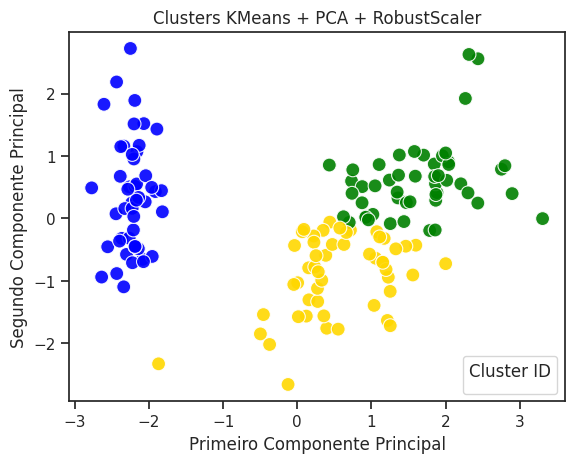

In [284]:
plot_scatter(X=X_pca['Componente_1'],
             Y=X_pca['Componente_2'],
             hue=final_labels_pca_robust, 
             paletaCores=['green', 'gold', 'blue'],
             tamanhoPonto=100, 
             transparencia=0.9, 
             titulo='Clusters KMeans + PCA + RobustScaler',
             xlabel='Primeiro Componente Principal',
             ylabel='Segundo Componente Principal',
             
            );

In [167]:
kmeans_evaluation_pca_robust = evaluate_multiple_clusters(X_pca_robust, y_true, k_range_to_test, algorithm='kmeans')

### HCluster + PCA

#### HCluster + PCA + StandarScaler

In [195]:
final_k_hc_pca  = n_cluster
final_labels_hc_pca , final_inertia_hc_pca , final_model_hc_pca  = run_single_cluster(X_pca, final_k_hc_pca , algorithm='hcluster')

print(f"\nModelo Hcluester final treinado {final_k_hc_pca}")


Modelo Hcluester final treinado 3


In [173]:
hcluster_evaluation_pca = evaluate_multiple_clusters(X_pca, y_true, k_range_to_test, algorithm='hcluster')

#### HCluster + PCA + RobustScaler

In [194]:
final_k_hc_pca_robust  = n_cluster
final_labels_hc_pca_robust , final_inertia_hc_pca_robust , final_model_hc_pca_robust  = run_single_cluster(X_pca_robust, final_k_hc_robust , algorithm='hcluster')

print(f"\nModelo Hcluester final treinado {final_k_hc_pca_robust}")


Modelo Hcluester final treinado 3


In [172]:
hcluster_evaluation_pca_robust = evaluate_multiple_clusters(X_pca_robust, y_true, k_range_to_test, algorithm='hcluster')

### HCluster + PCA + RobustScaler

In [138]:
final_k_hc_robust_pca  = n_cluster
final_labels_hc_robust_pca , final_inertia_hc_robust_pca , final_model_hc_robust_pca  = run_single_cluster(X_pca_robust, final_k_hc_robust_pca , algorithm='hcluster')

print(f"\nModelo Hcluester final treinado {final_k_hc_robust_pca}")


Modelo Hcluester final treinado 3


### Geral Criterio avalia√ß√£o de cluster 

In [236]:
hcluster_evaluation

inertia  silhouette  davies_bouldin  calinski_harabasz       ari  \
k                                                                      
2       NaN    0.584346        0.590467         252.346858  0.568116   
3       NaN    0.463188        0.804003         223.370657  0.653693   
4       NaN    0.416350        0.897758         203.773001  0.592613   
5       NaN    0.370087        0.885934         206.722679  0.472308   
6       NaN    0.355798        0.883422         188.066455  0.381887   
7       NaN    0.331014        0.984416         178.977789  0.423905   
8       NaN    0.338950        0.951749         176.245916  0.387864   
9       NaN    0.351866        0.891087         177.949484  0.372189   
10      NaN    0.351515        0.854764         174.555427  0.339009   

    v_measure       nmi  fowlkes_mallows  
k                                         
2    0.733680  0.733680         0.771454  
3    0.748950  0.748950         0.776979  
4    0.681069  0.681069         0.717283  
5    0.631380  0.631380         0.625036  
6    0.592849  0.592849         0.552247  
7    0.610011  0.610011         0.585793  
8    0.591323  0.591323         0.556216  
9    0.580612  0.580612         0.543072  
10   0.565753  0.565753         0.515311

In [225]:
criterios_avaliacao_cluster = [kmeans_evaluation ,hcluster_evaluation, \
kmeans_evaluation_robust,hcluster_evaluation_robust, \
kmeans_evaluation_pca ,hcluster_evaluation_pca, \
kmeans_evaluation_pca_robust,hcluster_evaluation_pca_robust ]

In [228]:
criterios_avaliacao_cluster = {"kmeans_evaluation":kmeans_evaluation ,"hcluster_evaluation":hcluster_evaluation, \
"kmeans_evaluation_robust":kmeans_evaluation_robust,"hcluster_evaluation_robust":hcluster_evaluation_robust, \
"kmeans_evaluation_pca":kmeans_evaluation_pca ,"hcluster_evaluation_pca":hcluster_evaluation_pca, \
"kmeans_evaluation_pca_robust":kmeans_evaluation_pca_robust, "hcluster_evaluation_pca_robust":hcluster_evaluation_pca_robust }

In [230]:
avaliacoes_com_rotulo = [
    df.assign(modelo=nome) for nome, df in criterios_avaliacao_cluster.items()
]

# Concatena tudo em um √∫nico DataFrame
df_completo = pd.concat(avaliacoes_com_rotulo, ignore_index=True)


In [231]:
df_completo

inertia  silhouette  davies_bouldin  calinski_harabasz       ari  \
0   223.732006    0.580184        0.597555         248.903428  0.568116   
1   192.037174    0.478724        0.786801         156.143038  0.428951   
2   114.682216    0.387247        0.865605         205.949969  0.493292   
3    91.295445    0.347265        0.940632         201.987516  0.437172   
4    81.760261    0.336223        0.990627         182.549618  0.478868   
..         ...         ...             ...                ...       ...   
67         NaN    0.411516        0.787168         159.491988  0.393385   
68         NaN    0.400089        0.770802         156.500675  0.306160   
69         NaN    0.400361        0.737614         161.091850  0.279895   
70         NaN    0.383852        0.832629         160.680740  0.316509   
71         NaN    0.356412        0.835967         157.910198  0.274798   

    v_measure       nmi  fowlkes_mallows                          modelo  
0    0.733680  0.733680         0.771454               kmeans_evaluation  
1    0.587378  0.587378         0.661310               kmeans_evaluation  
2    0.609087  0.609087         0.647329               kmeans_evaluation  
3    0.590811  0.590811         0.596313               kmeans_evaluation  
4    0.633982  0.633982         0.628443               kmeans_evaluation  
..        ...       ...              ...                             ...  
67   0.519065  0.519065         0.565726  hcluster_evaluation_pca_robust  
68   0.488853  0.488853         0.492989  hcluster_evaluation_pca_robust  
69   0.479574  0.479574         0.468247  hcluster_evaluation_pca_robust  
70   0.505471  0.505471         0.492410  hcluster_evaluation_pca_robust  
71   0.492284  0.492284         0.454521  hcluster_evaluation_pca_robust  

[72 rows x 9 columns]

In [234]:
def avaliar_modelos(df, reverse_metrics=None, metricas_usadas=None):
    """
    Avalia e ordena modelos com base em m√©tricas agrupadas por 'modelo'.

    Par√¢metros:
    - df: DataFrame com as m√©tricas de avalia√ß√£o e coluna 'modelo'
    - reverse_metrics: lista com m√©tricas onde menor valor √© melhor (ex: inertia, davies_bouldin)
    - metricas_usadas: lista de m√©tricas a considerar. Se None, usa todas menos 'modelo'

    Retorna:
    - DataFrame com ranking dos modelos
    """

    if reverse_metrics is None:
        reverse_metrics = ['inertia', 'davies_bouldin']
    
    if metricas_usadas is None:
        metricas_usadas = [col for col in df.columns if col != 'modelo']
    
    # Agrupa por modelo e calcula a m√©dia de cada m√©trica
    df_mean = df.groupby('modelo')[metricas_usadas].mean()

    # Inverte m√©tricas onde menor valor √© melhor (para normalizar no mesmo sentido)
    df_invertida = df_mean.copy()
    for col in reverse_metrics:
        if col in df_invertida.columns:
            df_invertida[col] = -df_invertida[col]

    # Normaliza as m√©tricas para [0, 1] (quanto maior, melhor)
    scaler = MinMaxScaler()
    df_normalizada = pd.DataFrame(
        scaler.fit_transform(df_invertida),
        columns=df_invertida.columns,
        index=df_invertida.index
    )

    # Soma das m√©tricas normalizadas como escore final
    df_normalizada['score_total'] = df_normalizada.sum(axis=1)

    # Ordena do melhor para o pior
    df_rank = df_normalizada.sort_values(by='score_total', ascending=False)

    return df_rank

In [238]:
# Vale ressaltar que a fun√ß√£o avalia cada modelo em rela√ß√£o a m√©dia dos resultados obtido para 9 rodas com k variando de 2 a 10 clusteres
# ao avaliar os modelos pelas metricas de classifica√ß√£o comparando o valor previsto do cluster com rotulo real, entendera-se qual o melhor
# pois o score abaixo soma o valor de cada criterio de avalia√ß√£o de cluster e o scor_tota√ß ordena qual teve maior valor
avaliar_modelos(df_completo)

inertia  silhouette  davies_bouldin  \
modelo                                                                 
hcluster_evaluation                  NaN    0.530148        0.526193   
hcluster_evaluation_pca              NaN    0.530148        0.526193   
kmeans_evaluation_pca           0.082508    0.601471        0.565428   
kmeans_evaluation               0.000000    0.000000        0.000000   
hcluster_evaluation_pca_robust       NaN    1.000000        1.000000   
hcluster_evaluation_robust           NaN    0.779767        0.881933   
kmeans_evaluation_robust        0.995557    0.301882        0.246622   
kmeans_evaluation_pca_robust    1.000000    0.313542        0.264458   

                                calinski_harabasz       ari  v_measure  \
modelo                                                                   
hcluster_evaluation                      1.000000  1.000000   1.000000   
hcluster_evaluation_pca                  1.000000  1.000000   1.000000   
kmeans_evaluation_pca                    0.876979  0.639092   0.651235   
kmeans_evaluation                        0.607412  0.378604   0.564887   
hcluster_evaluation_pca_robust           0.216528  0.012522   0.089127   
hcluster_evaluation_robust               0.117881  0.064859   0.102751   
kmeans_evaluation_robust                 0.014273  0.000000   0.037635   
kmeans_evaluation_pca_robust             0.000000  0.005120   0.000000   

                                     nmi  fowlkes_mallows  score_total  
modelo                                                                  
hcluster_evaluation             1.000000         1.000000     6.056341  
hcluster_evaluation_pca         1.000000         1.000000     6.056341  
kmeans_evaluation_pca           0.651235         0.779999     4.847948  
kmeans_evaluation               0.564887         0.510461     2.626251  
hcluster_evaluation_pca_robust  0.089127         0.089312     2.496616  
hcluster_evaluation_robust      0.102751         0.140203     2.190144  
kmeans_evaluation_robust        0.037635         0.000000     1.633604  
kmeans_evaluation_pca_robust    0.000000         0.003422     1.586541

# KDD 5 Avalia√ß√£o

## Interpreta√ß√£o de resultados 

## Valida√ß√£o de padr√µes/modelos

In [188]:
def evaluate_clustering_as_classification(y_true, y_pred_clusters):
    """
    Avalia os resultados do clustering usando m√©tricas de classifica√ß√£o ap√≥s
    mapear os r√≥tulos dos clusters para os r√≥tulos reais da classe majorit√°ria.

    Args:
        y_true (pd.Series): Os r√≥tulos verdadeiros.
        y_pred_clusters (np.ndarray): Os r√≥tulos atribu√≠dos pelo algoritmo de cluster.

    Returns:
        dict: Um dicion√°rio com a acur√°cia e o relat√≥rio de classifica√ß√£o.
    """
    # 1. Cria a tabela de conting√™ncia para encontrar a classe majorit√°ria
    contingency_matrix = pd.crosstab(y_true, y_pred_clusters)
    
    # 2. Cria o dicion√°rio de mapeamento
    # idxmax(axis=0) encontra o nome da classe real (√≠ndice) com o maior valor em cada coluna (cluster)
    label_map = contingency_matrix.idxmax(axis=0)
    
    # 3. Mapea os r√≥tulos dos clusters para os nomes das classes reais
    y_pred_mapped = pd.Series(y_pred_clusters).map(label_map)
    
    # 4. Calcula as m√©tricas de classifica√ß√£o
    accuracy = accuracy_score(y_true, y_pred_mapped)
    report = classification_report(y_true, y_pred_mapped, output_dict=True)
    
    return {
        'accuracy': accuracy,
        'classification_report': report,
        'contingency_matrix': contingency_matrix
    }


## KMEANS PLOT's Criterios

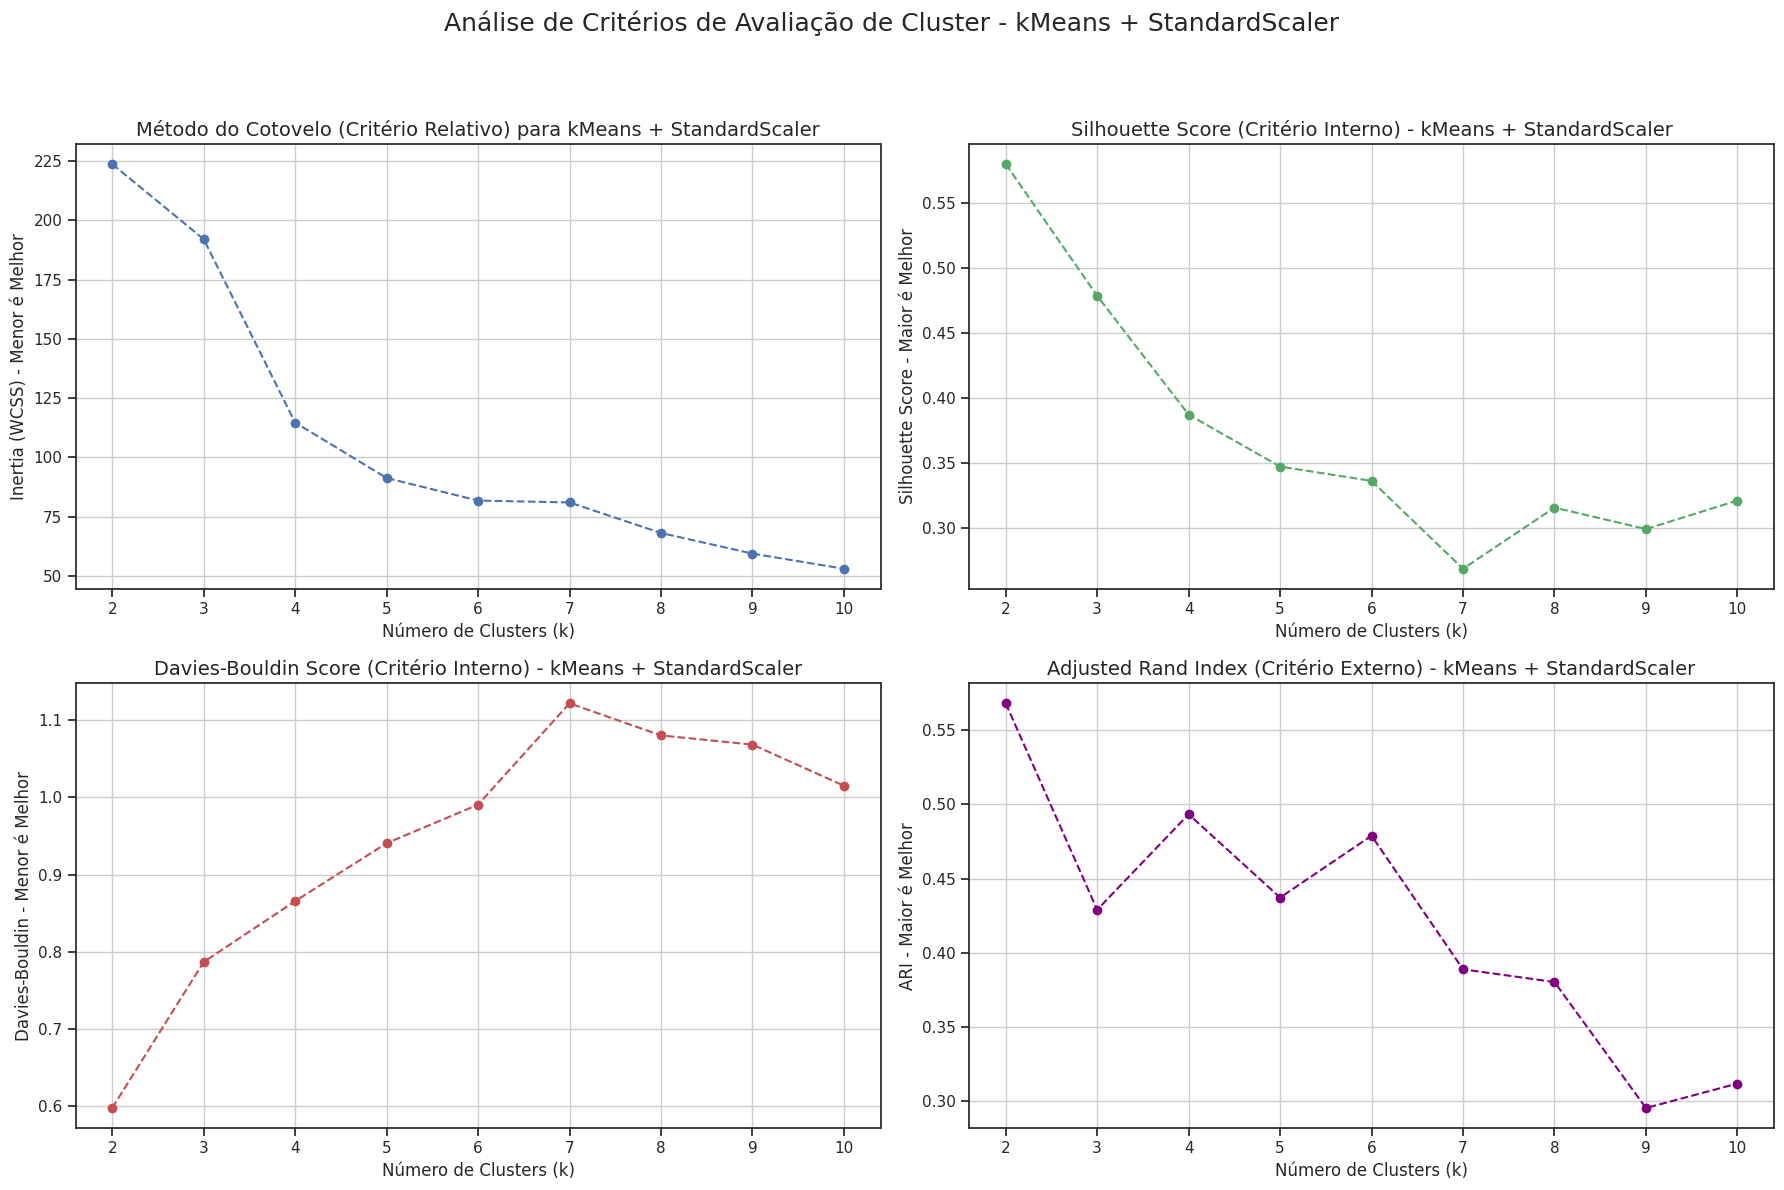

In [198]:
plot_clustering_evaluation(kmeans_evaluation,titulo="kMeans + StandardScaler" )

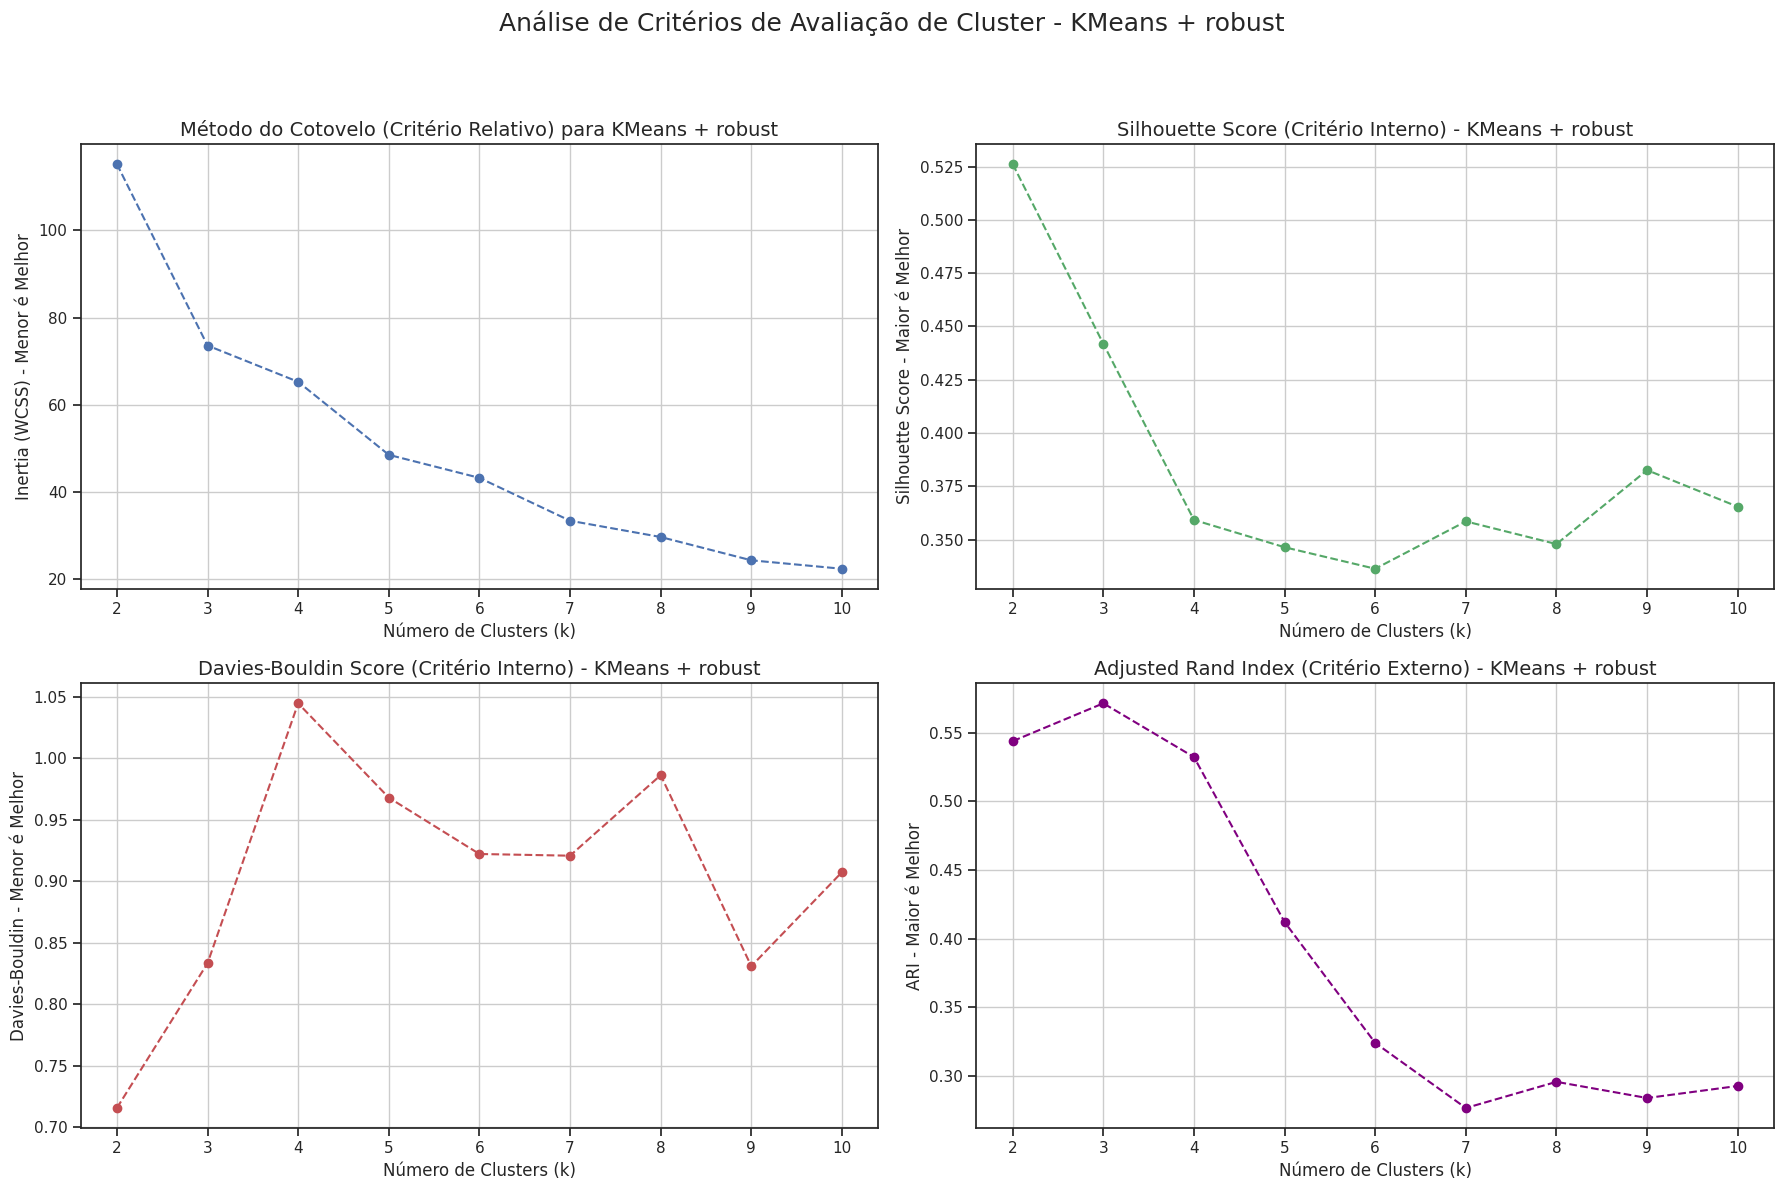

In [199]:
plot_clustering_evaluation(kmeans_evaluation_robust, titulo='KMeans + robust') #final_labels_robust, final_inertia_robust, final_model_robust

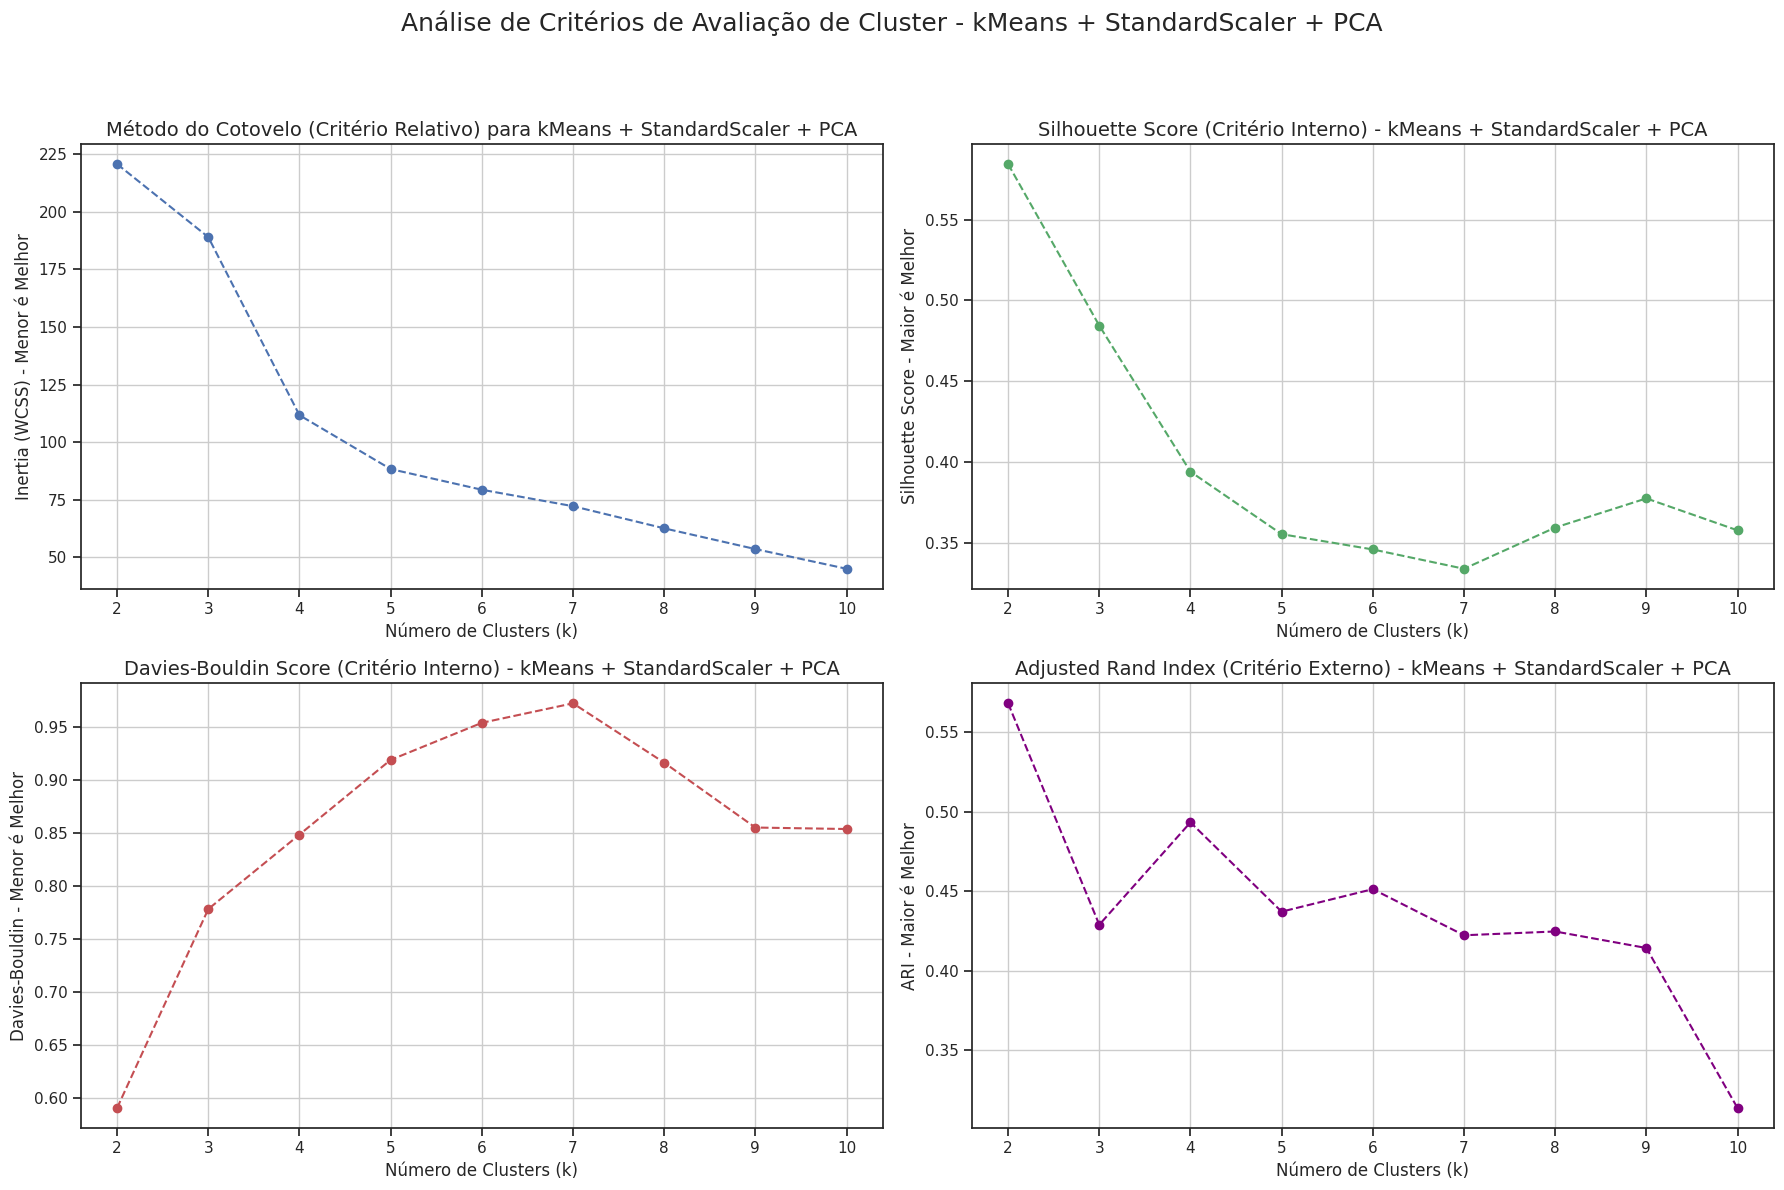

In [200]:
plot_clustering_evaluation(kmeans_evaluation_pca ,titulo="kMeans + StandardScaler + PCA" )

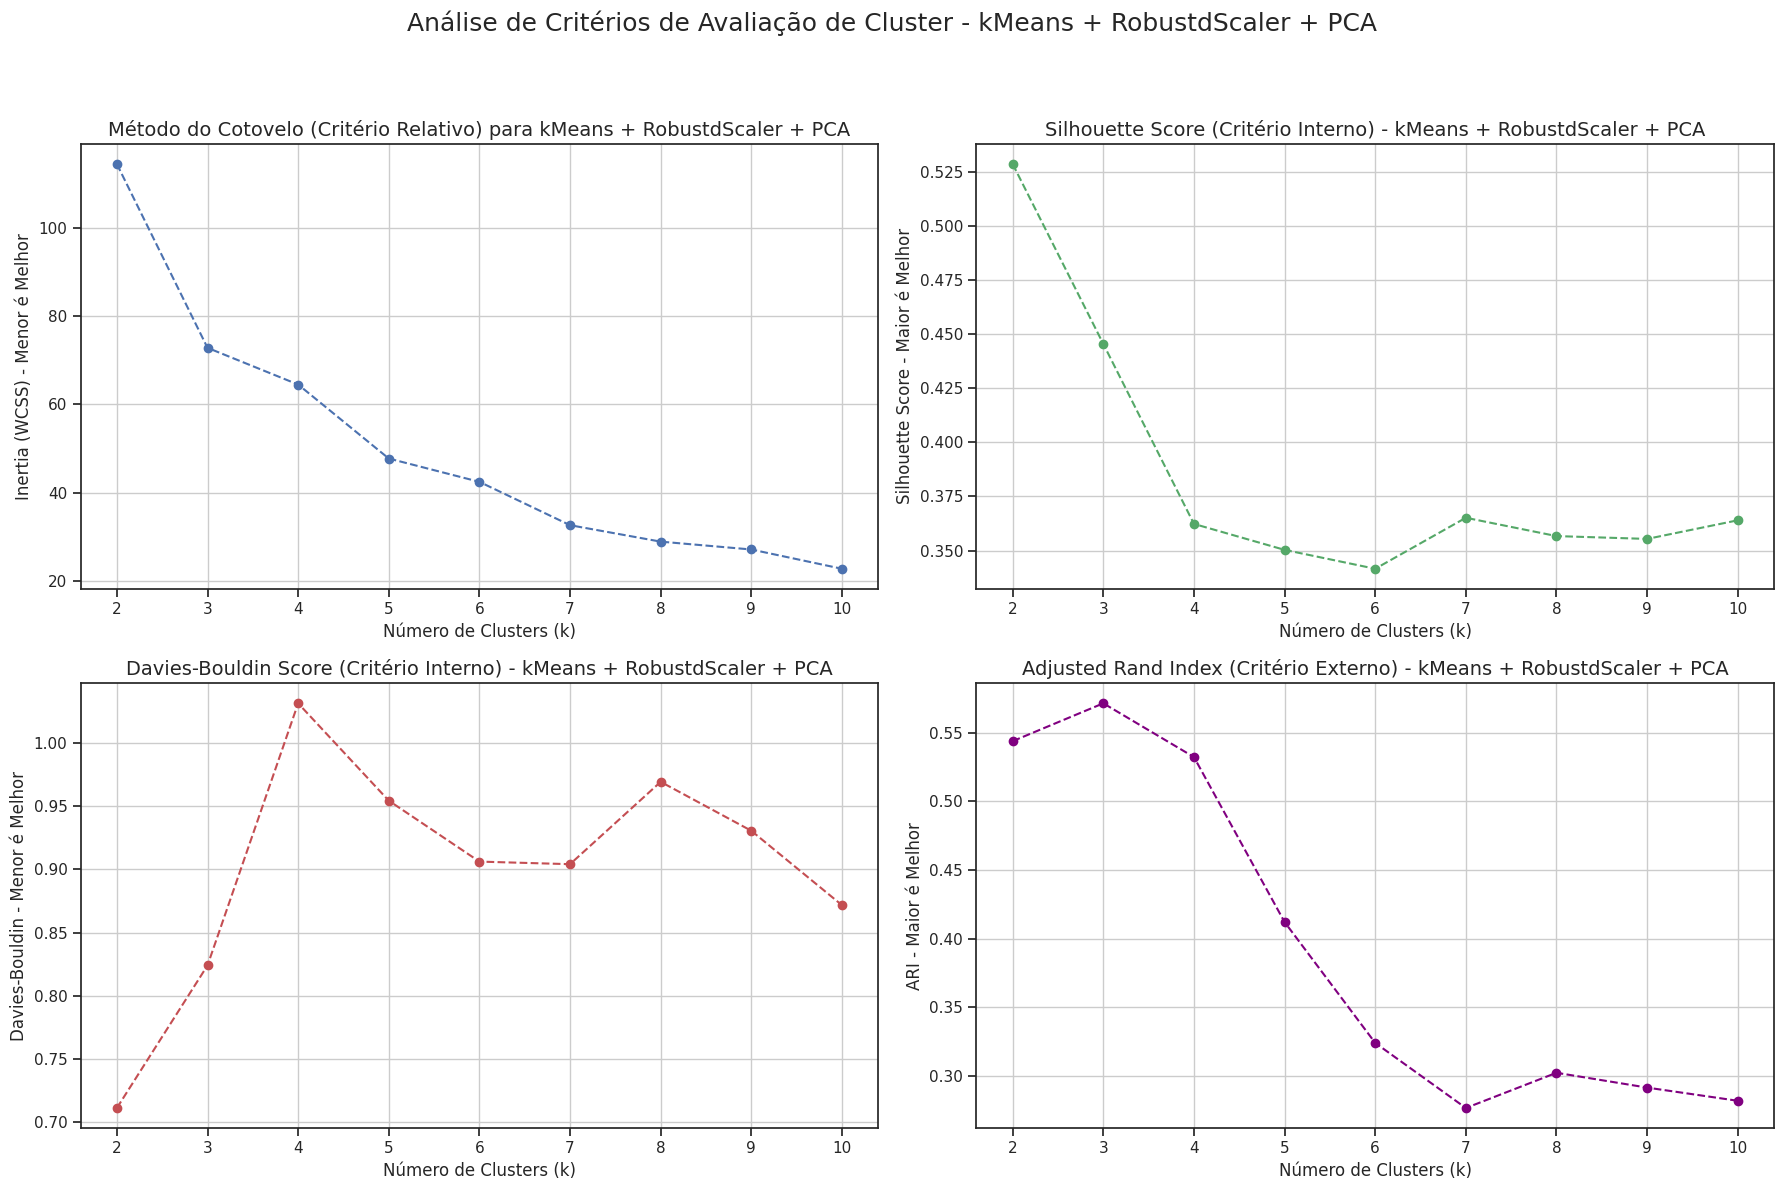

In [201]:
plot_clustering_evaluation(kmeans_evaluation_pca_robust ,titulo="kMeans + RobustdScaler + PCA" )

## Hcluster Plotss Criterio 

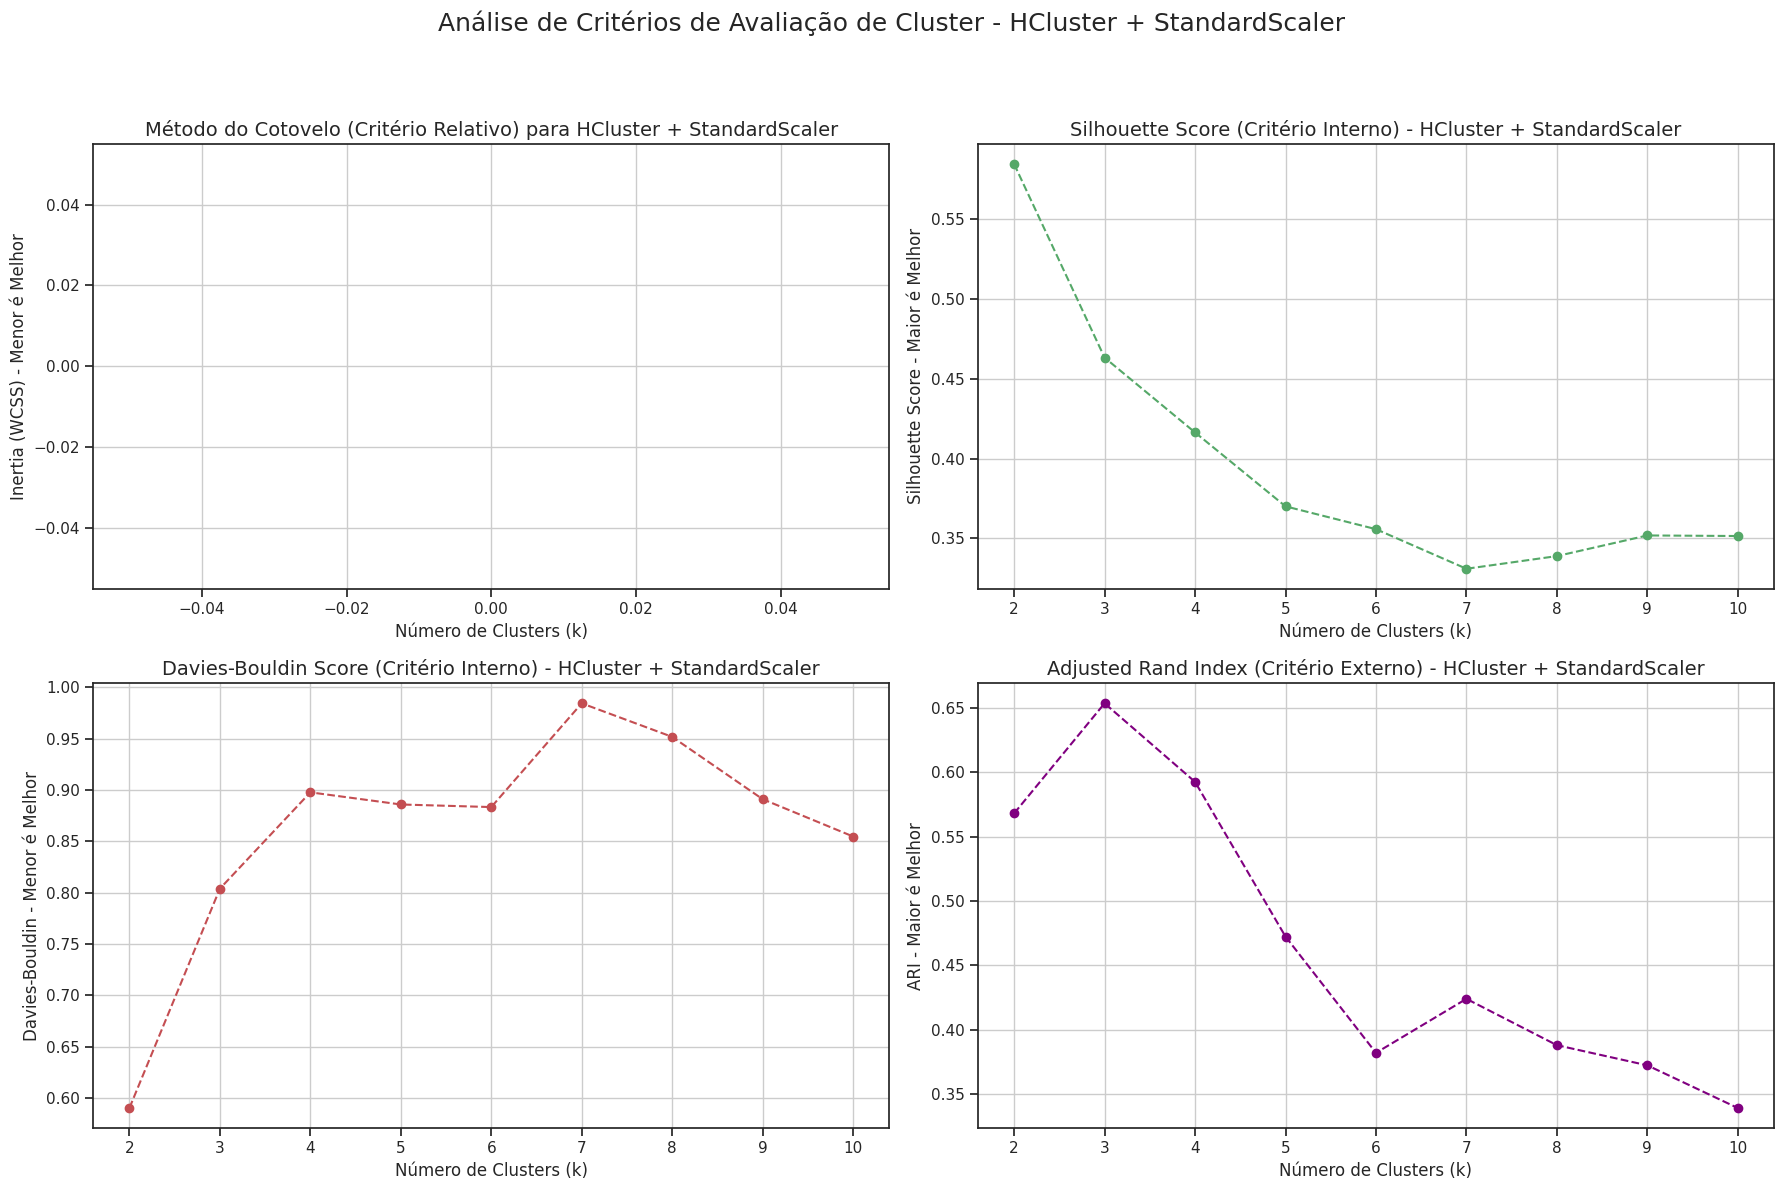

In [185]:
plot_clustering_evaluation(hcluster_evaluation, titulo='HCluster + StandardScaler')

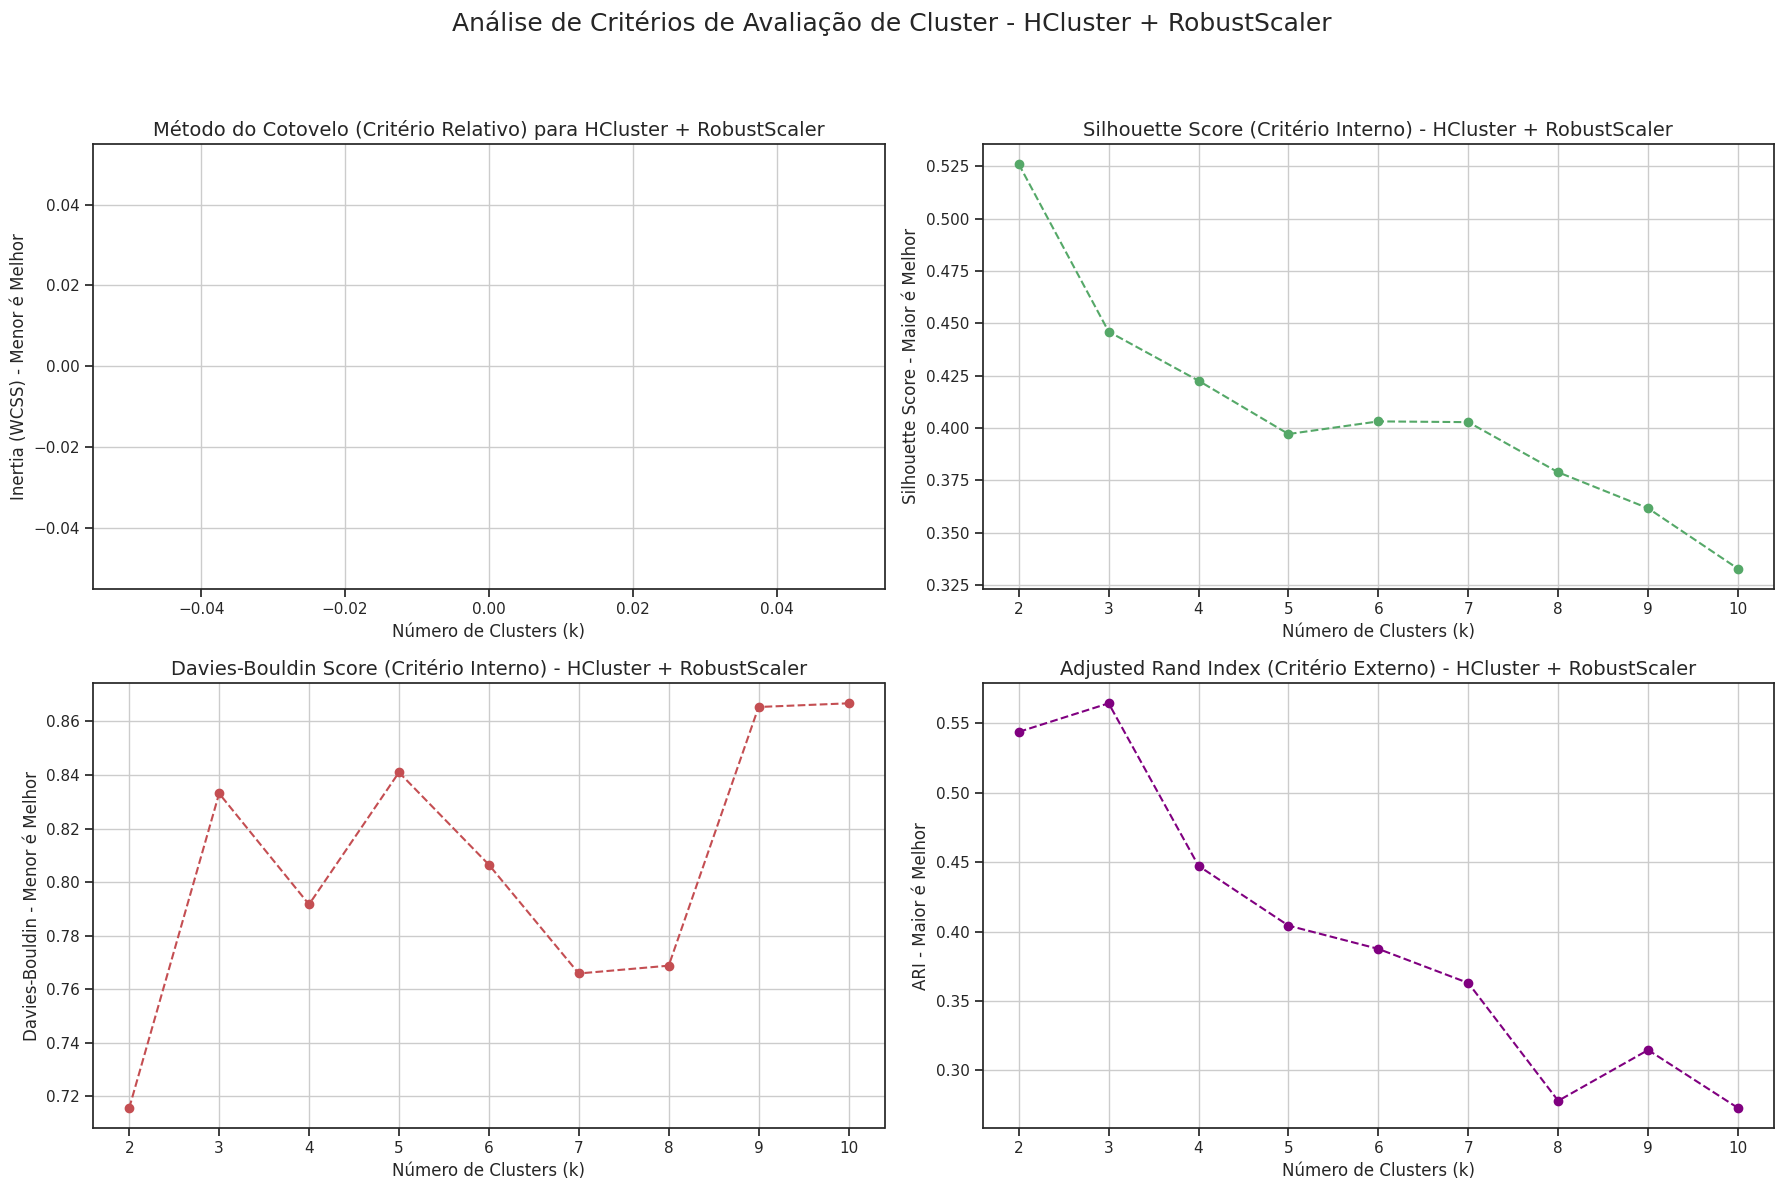

In [182]:
plot_clustering_evaluation(hcluster_evaluation_robust ,titulo="HCluster + RobustScaler" )

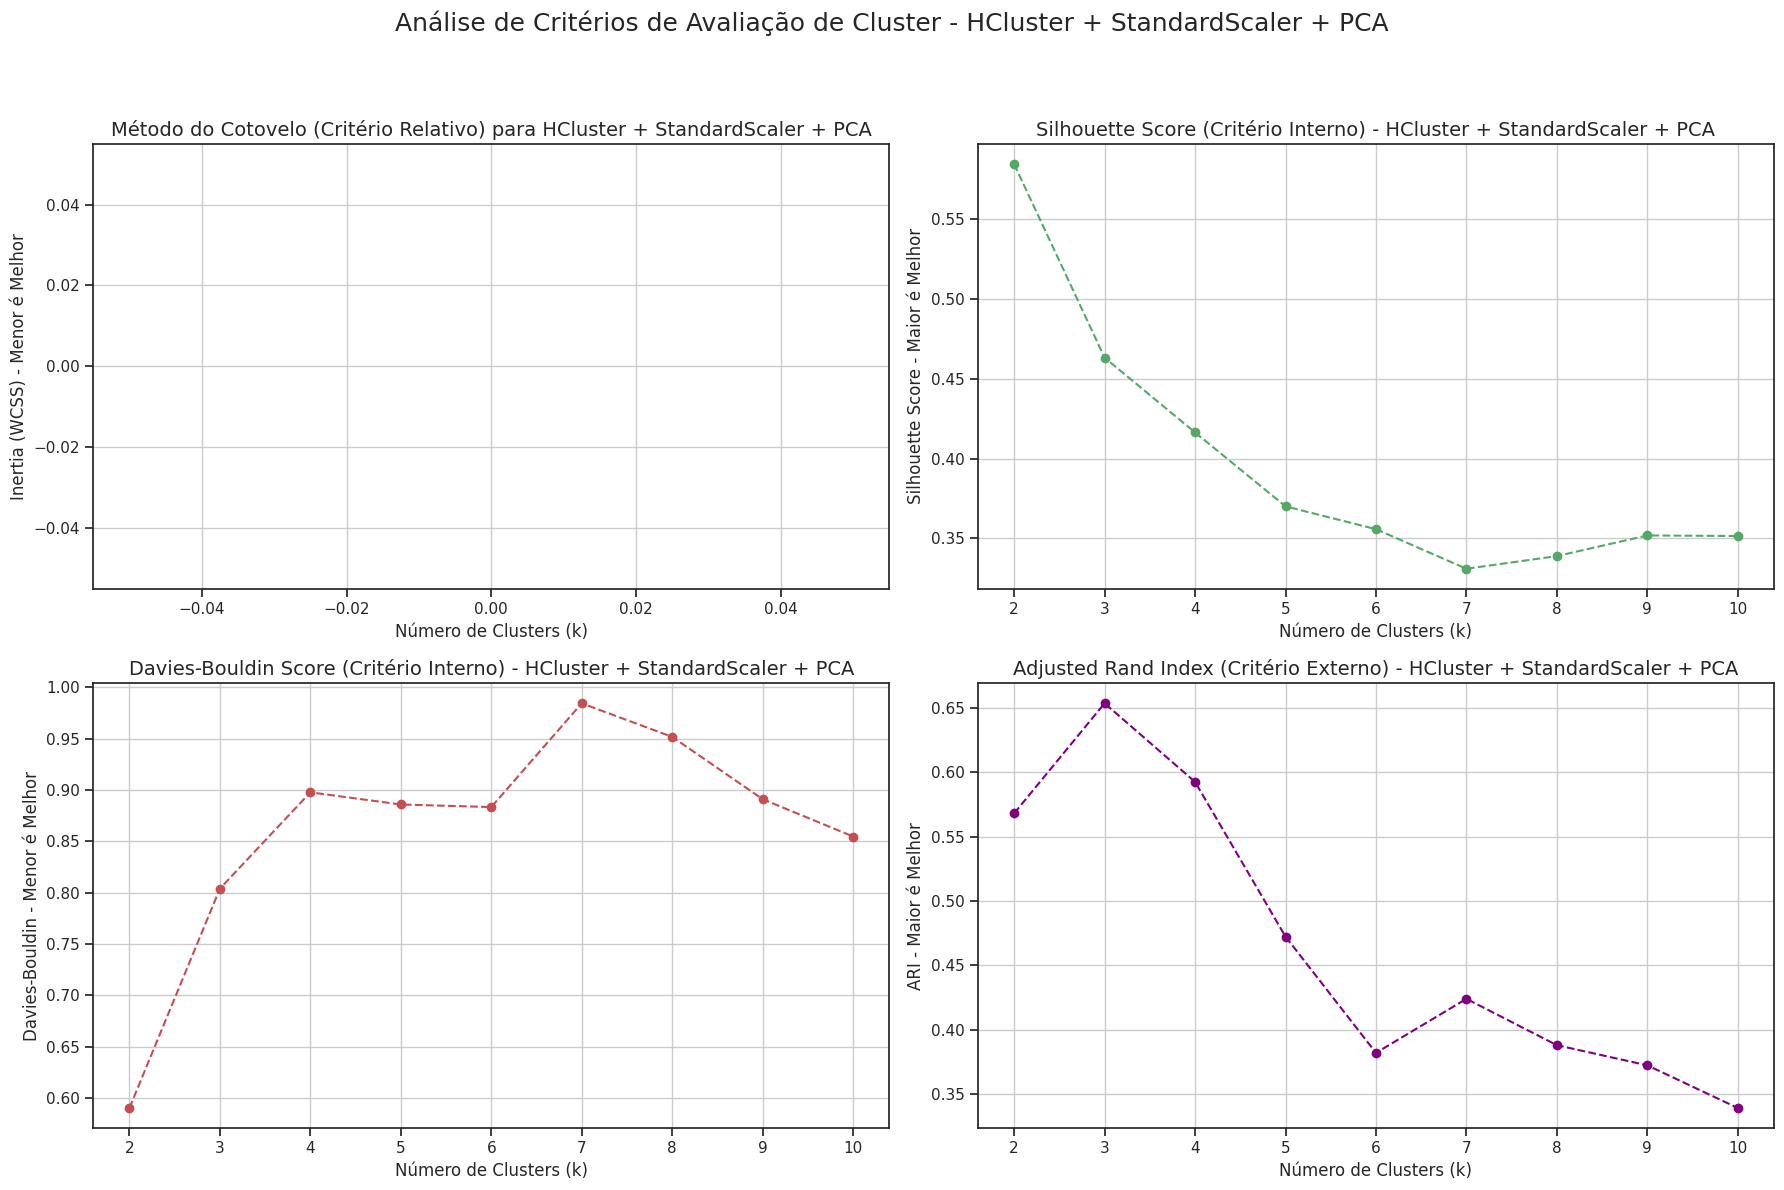

In [202]:
plot_clustering_evaluation(hcluster_evaluation_pca ,titulo="HCluster + StandardScaler + PCA" )

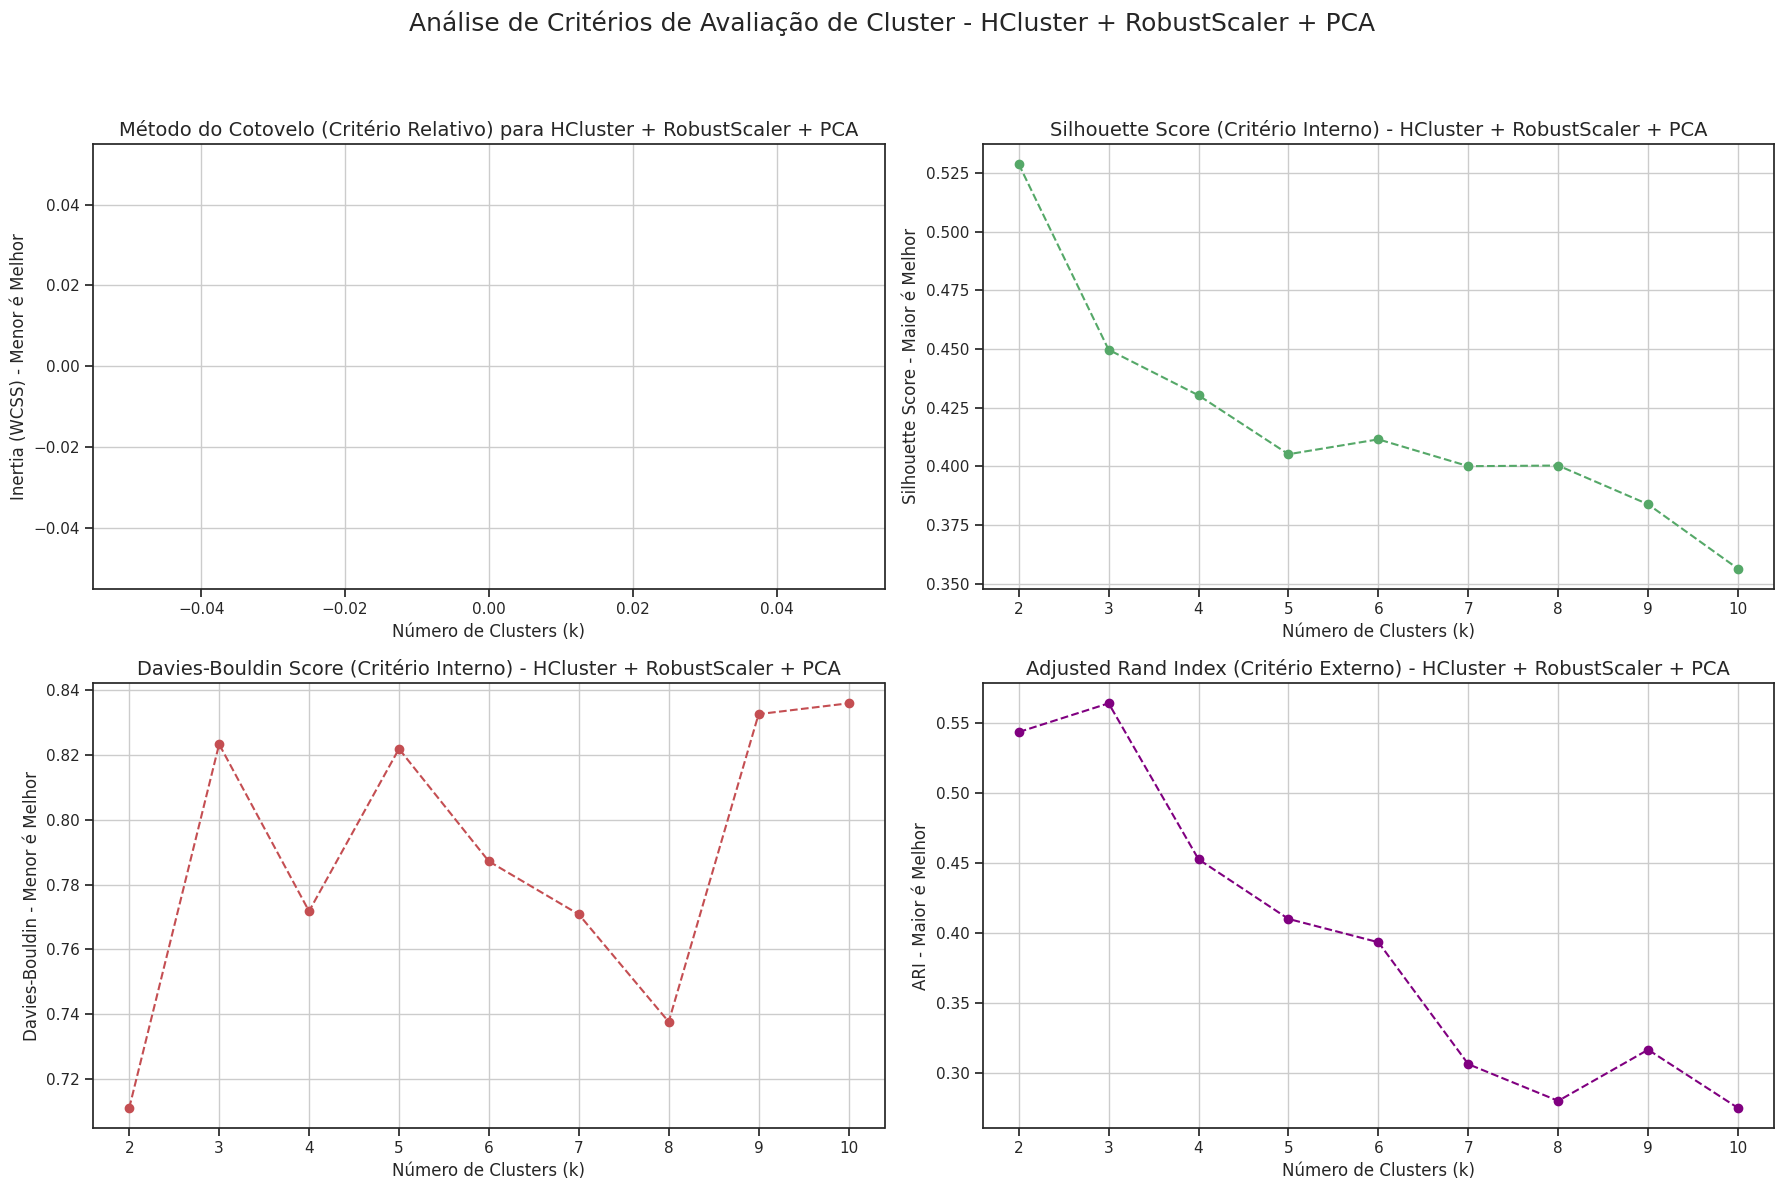

In [203]:
plot_clustering_evaluation(hcluster_evaluation_pca_robust ,titulo="HCluster + RobustScaler + PCA" )

### M√©tricas avalia√ß√£o 

#### Para kmeans

In [204]:
# j√° com modelo treinado final para k=3
# e os 'final_labels' e 'y_true'

# Avaliar os clusters usando m√©tricas de classifica√ß√£o
classification_results = evaluate_clustering_as_classification(y_true, final_labels)

# Exibir os resultados
print(f"Acur√°cia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precis√£o, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelat√≥rio de Classifica√ß√£o Detalhado:")
display(report_df)

# Para ver a tabela de confus√£o/conting√™ncia
print("\nTabela de Conting√™ncia (como os clusters foram mapeados):")
display(classification_results['contingency_matrix'])

Acur√°cia Mapeada: 0.6667

Relat√≥rio de Classifica√ß√£o Detalhado:


/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricW

precision    recall  f1-score     support
Iris-setosa       0.925926  1.000000  0.961538   50.000000
Iris-versicolor   0.000000  0.000000  0.000000   50.000000
Iris-virginica    0.520833  1.000000  0.684932   50.000000
accuracy          0.666667  0.666667  0.666667    0.666667
macro avg         0.482253  0.666667  0.548823  150.000000
weighted avg      0.482253  0.666667  0.548823  150.000000


Tabela de Conting√™ncia (como os clusters foram mapeados):


col_0             0   1   2
target                     
Iris-setosa       0  32  18
Iris-versicolor  46   0   4
Iris-virginica   50   0   0

In [205]:
classification_results = evaluate_clustering_as_classification(y_true, final_labels_pca)


print(f"Acur√°cia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precis√£o, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()

print("\nRelat√≥rio de Classifica√ß√£o Detalhado:")
display(report_df)

# Para ver a tabela de confus√£o/conting√™ncia
print("\nTabela de Conting√™ncia (como os clusters foram mapeados):")
display(classification_results['contingency_matrix'])

Acur√°cia Mapeada: 0.6667

Relat√≥rio de Classifica√ß√£o Detalhado:


/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricW

precision    recall  f1-score     support
Iris-setosa       0.925926  1.000000  0.961538   50.000000
Iris-versicolor   0.000000  0.000000  0.000000   50.000000
Iris-virginica    0.520833  1.000000  0.684932   50.000000
accuracy          0.666667  0.666667  0.666667    0.666667
macro avg         0.482253  0.666667  0.548823  150.000000
weighted avg      0.482253  0.666667  0.548823  150.000000


Tabela de Conting√™ncia (como os clusters foram mapeados):


col_0             0   1   2
target                     
Iris-setosa       0  32  18
Iris-versicolor  46   0   4
Iris-virginica   50   0   0

In [206]:
classification_results = evaluate_clustering_as_classification(y_true, final_labels_robust)


print(f"Acur√°cia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precis√£o, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelat√≥rio de Classifica√ß√£o Detalhado:")
display(report_df)

# Para ver a tabela de confus√£o/conting√™ncia
print("\nTabela de Conting√™ncia (como os clusters foram mapeados):usando Kmeans + escalonamento por RobustScaler ")
display(classification_results['contingency_matrix'])

Acur√°cia Mapeada: 0.8067

Relat√≥rio de Classifica√ß√£o Detalhado:


precision    recall  f1-score     support
Iris-setosa       1.000000  0.980000  0.989899   50.000000
Iris-versicolor   0.705882  0.720000  0.712871   50.000000
Iris-virginica    0.720000  0.720000  0.720000   50.000000
accuracy          0.806667  0.806667  0.806667    0.806667
macro avg         0.808627  0.806667  0.807590  150.000000
weighted avg      0.808627  0.806667  0.807590  150.000000


Tabela de Conting√™ncia (como os clusters foram mapeados):usando Kmeans + escalonamento por RobustScaler 


col_0             0   1   2
target                     
Iris-setosa       0   1  49
Iris-versicolor  14  36   0
Iris-virginica   36  14   0

In [207]:
classification_results = evaluate_clustering_as_classification(y_true, final_labels_pca_robust)


print(f"Acur√°cia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precis√£o, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelat√≥rio de Classifica√ß√£o Detalhado:")
display(report_df)

# Para ver a tabela de confus√£o/conting√™ncia
print("\nTabela de Conting√™ncia (como os clusters foram mapeados):usando Kmeans + escalonamento por RobustScaler + PCA ")
display(classification_results['contingency_matrix'])

Acur√°cia Mapeada: 0.8067

Relat√≥rio de Classifica√ß√£o Detalhado:


precision    recall  f1-score     support
Iris-setosa       1.000000  0.980000  0.989899   50.000000
Iris-versicolor   0.705882  0.720000  0.712871   50.000000
Iris-virginica    0.720000  0.720000  0.720000   50.000000
accuracy          0.806667  0.806667  0.806667    0.806667
macro avg         0.808627  0.806667  0.807590  150.000000
weighted avg      0.808627  0.806667  0.807590  150.000000


Tabela de Conting√™ncia (como os clusters foram mapeados):usando Kmeans + escalonamento por RobustScaler + PCA 


col_0             0   1   2
target                     
Iris-setosa       0   1  49
Iris-versicolor  14  36   0
Iris-virginica   36  14   0

#### Para hcluster

In [208]:
final_labels_hc
# j√° com modelo treinado final para k_hc=3
# e os 'final_labels_hc' e 'y_true'

# Avaliar os clusters usando m√©tricas de classifica√ß√£o
classification_results = evaluate_clustering_as_classification(y_true, final_labels_hc)

# Exibir os resultados
print(f"Acur√°cia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precis√£o, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelat√≥rio de Classifica√ß√£o Detalhado:")
display(report_df)

# Para ver a tabela de confus√£o/conting√™ncia
print("\nTabela de Conting√™ncia (como os clusters HCluestr foram mapeados):")
display(classification_results['contingency_matrix'])

Acur√°cia Mapeada: 0.8267

Relat√≥rio de Classifica√ß√£o Detalhado:


precision    recall  f1-score     support
Iris-setosa       1.000000  0.980000  0.989899   50.000000
Iris-versicolor   0.900000  0.540000  0.675000   50.000000
Iris-virginica    0.676056  0.960000  0.793388   50.000000
accuracy          0.826667  0.826667  0.826667    0.826667
macro avg         0.858685  0.826667  0.819429  150.000000
weighted avg      0.858685  0.826667  0.819429  150.000000


Tabela de Conting√™ncia (como os clusters HCluestr foram mapeados):


col_0             0   1   2
target                     
Iris-setosa       0  49   1
Iris-versicolor  23   0  27
Iris-virginica   48   0   2

In [209]:
final_labels_hc
# j√° com modelo treinado final para k_hc=3
# e os 'final_labels_hc' e 'y_true'

# Avaliar os clusters usando m√©tricas de classifica√ß√£o
classification_results = evaluate_clustering_as_classification(y_true, final_labels_hc_pca)

# Exibir os resultados
print(f"Acur√°cia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precis√£o, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelat√≥rio de Classifica√ß√£o Detalhado:")
display(report_df)

# Para ver a tabela de confus√£o/conting√™ncia
print("\nTabela de Conting√™ncia (como os clusters HCluestr foram mapeados): com pca ")
display(classification_results['contingency_matrix'])

Acur√°cia Mapeada: 0.8467

Relat√≥rio de Classifica√ß√£o Detalhado:


precision    recall  f1-score     support
Iris-setosa       1.000000  1.000000  1.000000   50.000000
Iris-versicolor   0.684932  1.000000  0.813008   50.000000
Iris-virginica    1.000000  0.540000  0.701299   50.000000
accuracy          0.846667  0.846667  0.846667    0.846667
macro avg         0.894977  0.846667  0.838102  150.000000
weighted avg      0.894977  0.846667  0.838102  150.000000


Tabela de Conting√™ncia (como os clusters HCluestr foram mapeados):


col_0             0   1   2
target                     
Iris-setosa       0  50   0
Iris-versicolor  50   0   0
Iris-virginica   23   0  27

In [210]:
final_labels_hc
# j√° com modelo treinado final para k_hc=3
# e os 'final_labels_hc' e 'y_true'

# Avaliar os clusters usando m√©tricas de classifica√ß√£o
classification_results = evaluate_clustering_as_classification(y_true, final_labels_hc_robust)

# Exibir os resultados
print(f"Acur√°cia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precis√£o, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelat√≥rio de Classifica√ß√£o Detalhado:")
display(report_df)

# Para ver a tabela de confus√£o/conting√™ncia
print("\nTabela de Conting√™ncia (como os clusters HCluestr foram mapeados): com pca ")
display(classification_results['contingency_matrix'])

Acur√°cia Mapeada: 0.8000

Relat√≥rio de Classifica√ß√£o Detalhado:


precision  recall  f1-score  support
Iris-setosa       1.000000    0.98  0.989899     50.0
Iris-versicolor   0.661290    0.82  0.732143     50.0
Iris-virginica    0.769231    0.60  0.674157     50.0
accuracy          0.800000    0.80  0.800000      0.8
macro avg         0.810174    0.80  0.798733    150.0
weighted avg      0.810174    0.80  0.798733    150.0


Tabela de Conting√™ncia (como os clusters HCluestr foram mapeados): com pca 


col_0             0   1   2
target                     
Iris-setosa      49   1   0
Iris-versicolor   0  41   9
Iris-virginica    0  20  30

In [211]:
final_labels_hc
# j√° com modelo treinado final para k_hc=3
# e os 'final_labels_hc' e 'y_true'

# Avaliar os clusters usando m√©tricas de classifica√ß√£o
classification_results = evaluate_clustering_as_classification(y_true, final_labels_hc_pca_robust)

# Exibir os resultados
print(f"Acur√°cia Mapeada: {classification_results['accuracy']:.4f}")

# Para ver precis√£o, recall e f1-score para cada classe
report_df = pd.DataFrame(classification_results['classification_report']).transpose()
print("\nRelat√≥rio de Classifica√ß√£o Detalhado:")
display(report_df)

# Para ver a tabela de confus√£o/conting√™ncia
print("\nTabela de Conting√™ncia (como os clusters HCluestr foram mapeados): com pca ")
display(classification_results['contingency_matrix'])

Acur√°cia Mapeada: 0.8000

Relat√≥rio de Classifica√ß√£o Detalhado:


precision  recall  f1-score  support
Iris-setosa       1.000000    0.98  0.989899     50.0
Iris-versicolor   0.661290    0.82  0.732143     50.0
Iris-virginica    0.769231    0.60  0.674157     50.0
accuracy          0.800000    0.80  0.800000      0.8
macro avg         0.810174    0.80  0.798733    150.0
weighted avg      0.810174    0.80  0.798733    150.0


Tabela de Conting√™ncia (como os clusters HCluestr foram mapeados): com pca 


col_0             0   1   2
target                     
Iris-setosa      49   1   0
Iris-versicolor   0  41   9
Iris-virginica    0  20  30

In [239]:
def exibir_resultados_classificacao(y_true, predicted_labels, descricao=''):
    """
    Avalia e exibe as m√©tricas de classifica√ß√£o entre r√≥tulos reais e r√≥tulos previstos de clustering.

    Par√¢metros:
    - y_true: r√≥tulos verdadeiros
    - predicted_labels: r√≥tulos do clustering
    - descricao: texto adicional para identificar o modelo
    """
    results = evaluate_clustering_as_classification(y_true, predicted_labels)

    print(f"\nüìå Avalia√ß√£o: {descricao}")
    print(f"Acur√°cia Mapeada: {results['accuracy']:.4f}")

    print("\nüìä Relat√≥rio de Classifica√ß√£o Detalhado:")
    display(pd.DataFrame(results['classification_report']).transpose())

    print("\nüß© Tabela de Conting√™ncia:")
    display(results['contingency_matrix'])

    return results


In [240]:
def avaliar_varios_modelos(y_true, modelos_labels_dict):
    """
    Avalia m√∫ltiplas predi√ß√µes de clustering e retorna resultados em dicion√°rio.

    Par√¢metros:
    - y_true: r√≥tulos reais
    - modelos_labels_dict: dicion√°rio com {nome_modelo: r√≥tulos_preditos}

    Retorna:
    - dict com {nome_modelo: resultados_classificacao}
    """
    resultados = {}
    for nome_modelo, labels_preditos in modelos_labels_dict.items():
        resultados[nome_modelo] = exibir_resultados_classificacao(
            y_true, labels_preditos, descricao=nome_modelo
        )
    return resultados

In [247]:
def gerar_ranking_modelos(resultados_dict):
    """
    Gera um DataFrame com as m√©tricas globais (accuracy, f1, recall, precision)
    de todos os modelos avaliados, ordenado por f1, accuracy, recall e precision.
    F1 mais importante, depois acuracia e sucessivamente.

    Par√¢metros:
    - resultados_dict: dicion√°rio retornado por `avaliar_varios_modelos()`

    Retorna:
    - DataFrame ordenado do melhor para o pior modelo
    """
    ranking_data = []

    for nome_modelo, resultado in resultados_dict.items():
        report = resultado["classification_report"]
        # As m√©tricas m√©dias ponderadas ("weighted avg") s√£o as mais representativas no geral
        weighted_avg = report.get("weighted avg", {})
        ranking_data.append({
            "modelo": nome_modelo,
            "f1_score": weighted_avg.get("f1-score", 0),
            "accuracy": resultado.get("accuracy", 0),
            "recall": weighted_avg.get("recall", 0),
            "precision": weighted_avg.get("precision", 0),
        })

    ranking_df = pd.DataFrame(ranking_data)
    ranking_df = ranking_df.sort_values(
        by=["f1_score", "accuracy", "recall", "precision"], ascending=False
    ).reset_index(drop=True)

    return ranking_df


In [248]:
# Dicion√°rio de r√≥tulos gerados por diferentes t√©cnicas de clustering
modelos_labels_dict = {
    "KMeans": final_labels,
    "KMeans + PCA": final_labels_pca,
    "KMeans + Robust": final_labels_robust,
    "KMeans + PCA + Robust": final_labels_pca_robust,
    "HC": final_labels_hc,
    "HC + PCA": final_labels_hc_pca,
    "HC + Robust": final_labels_hc_robust,
    "HC + PCA + Robust": final_labels_hc_pca_robust,
}

In [249]:
# Executa a avalia√ß√£o para todos os modelos
resultados_todos = avaliar_varios_modelos(y_true, modelos_labels_dict)


üìå Avalia√ß√£o: KMeans
Acur√°cia Mapeada: 0.6667

üìä Relat√≥rio de Classifica√ß√£o Detalhado:


/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricW

precision    recall  f1-score     support
Iris-setosa       0.925926  1.000000  0.961538   50.000000
Iris-versicolor   0.000000  0.000000  0.000000   50.000000
Iris-virginica    0.520833  1.000000  0.684932   50.000000
accuracy          0.666667  0.666667  0.666667    0.666667
macro avg         0.482253  0.666667  0.548823  150.000000
weighted avg      0.482253  0.666667  0.548823  150.000000


üß© Tabela de Conting√™ncia:


col_0             0   1   2
target                     
Iris-setosa       0  32  18
Iris-versicolor  46   0   4
Iris-virginica   50   0   0


üìå Avalia√ß√£o: KMeans + PCA
Acur√°cia Mapeada: 0.6667

üìä Relat√≥rio de Classifica√ß√£o Detalhado:


/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessandro/Documentos/academico/mestrado/2025/aprendizado-maquina/trabalho-002/trabalho2Env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricW

precision    recall  f1-score     support
Iris-setosa       0.925926  1.000000  0.961538   50.000000
Iris-versicolor   0.000000  0.000000  0.000000   50.000000
Iris-virginica    0.520833  1.000000  0.684932   50.000000
accuracy          0.666667  0.666667  0.666667    0.666667
macro avg         0.482253  0.666667  0.548823  150.000000
weighted avg      0.482253  0.666667  0.548823  150.000000


üß© Tabela de Conting√™ncia:


col_0             0   1   2
target                     
Iris-setosa       0  32  18
Iris-versicolor  46   0   4
Iris-virginica   50   0   0


üìå Avalia√ß√£o: KMeans + Robust
Acur√°cia Mapeada: 0.8067

üìä Relat√≥rio de Classifica√ß√£o Detalhado:


precision    recall  f1-score     support
Iris-setosa       1.000000  0.980000  0.989899   50.000000
Iris-versicolor   0.705882  0.720000  0.712871   50.000000
Iris-virginica    0.720000  0.720000  0.720000   50.000000
accuracy          0.806667  0.806667  0.806667    0.806667
macro avg         0.808627  0.806667  0.807590  150.000000
weighted avg      0.808627  0.806667  0.807590  150.000000


üß© Tabela de Conting√™ncia:


col_0             0   1   2
target                     
Iris-setosa       0   1  49
Iris-versicolor  14  36   0
Iris-virginica   36  14   0


üìå Avalia√ß√£o: KMeans + PCA + Robust
Acur√°cia Mapeada: 0.8067

üìä Relat√≥rio de Classifica√ß√£o Detalhado:


precision    recall  f1-score     support
Iris-setosa       1.000000  0.980000  0.989899   50.000000
Iris-versicolor   0.705882  0.720000  0.712871   50.000000
Iris-virginica    0.720000  0.720000  0.720000   50.000000
accuracy          0.806667  0.806667  0.806667    0.806667
macro avg         0.808627  0.806667  0.807590  150.000000
weighted avg      0.808627  0.806667  0.807590  150.000000


üß© Tabela de Conting√™ncia:


col_0             0   1   2
target                     
Iris-setosa       0   1  49
Iris-versicolor  14  36   0
Iris-virginica   36  14   0


üìå Avalia√ß√£o: HC
Acur√°cia Mapeada: 0.8267

üìä Relat√≥rio de Classifica√ß√£o Detalhado:


precision    recall  f1-score     support
Iris-setosa       1.000000  0.980000  0.989899   50.000000
Iris-versicolor   0.900000  0.540000  0.675000   50.000000
Iris-virginica    0.676056  0.960000  0.793388   50.000000
accuracy          0.826667  0.826667  0.826667    0.826667
macro avg         0.858685  0.826667  0.819429  150.000000
weighted avg      0.858685  0.826667  0.819429  150.000000


üß© Tabela de Conting√™ncia:


col_0             0   1   2
target                     
Iris-setosa       0  49   1
Iris-versicolor  23   0  27
Iris-virginica   48   0   2


üìå Avalia√ß√£o: HC + PCA
Acur√°cia Mapeada: 0.8467

üìä Relat√≥rio de Classifica√ß√£o Detalhado:


precision    recall  f1-score     support
Iris-setosa       1.000000  1.000000  1.000000   50.000000
Iris-versicolor   0.684932  1.000000  0.813008   50.000000
Iris-virginica    1.000000  0.540000  0.701299   50.000000
accuracy          0.846667  0.846667  0.846667    0.846667
macro avg         0.894977  0.846667  0.838102  150.000000
weighted avg      0.894977  0.846667  0.838102  150.000000


üß© Tabela de Conting√™ncia:


col_0             0   1   2
target                     
Iris-setosa       0  50   0
Iris-versicolor  50   0   0
Iris-virginica   23   0  27


üìå Avalia√ß√£o: HC + Robust
Acur√°cia Mapeada: 0.8000

üìä Relat√≥rio de Classifica√ß√£o Detalhado:


precision  recall  f1-score  support
Iris-setosa       1.000000    0.98  0.989899     50.0
Iris-versicolor   0.661290    0.82  0.732143     50.0
Iris-virginica    0.769231    0.60  0.674157     50.0
accuracy          0.800000    0.80  0.800000      0.8
macro avg         0.810174    0.80  0.798733    150.0
weighted avg      0.810174    0.80  0.798733    150.0


üß© Tabela de Conting√™ncia:


col_0             0   1   2
target                     
Iris-setosa      49   1   0
Iris-versicolor   0  41   9
Iris-virginica    0  20  30


üìå Avalia√ß√£o: HC + PCA + Robust
Acur√°cia Mapeada: 0.8000

üìä Relat√≥rio de Classifica√ß√£o Detalhado:


precision  recall  f1-score  support
Iris-setosa       1.000000    0.98  0.989899     50.0
Iris-versicolor   0.661290    0.82  0.732143     50.0
Iris-virginica    0.769231    0.60  0.674157     50.0
accuracy          0.800000    0.80  0.800000      0.8
macro avg         0.810174    0.80  0.798733    150.0
weighted avg      0.810174    0.80  0.798733    150.0


üß© Tabela de Conting√™ncia:


col_0             0   1   2
target                     
Iris-setosa      49   1   0
Iris-versicolor   0  41   9
Iris-virginica    0  20  30

In [252]:
resultados =gerar_ranking_modelos(resultados_todos)
resultados

modelo  f1_score  accuracy    recall  precision
0               HC + PCA  0.838102  0.846667  0.846667   0.894977
1                     HC  0.819429  0.826667  0.826667   0.858685
2        KMeans + Robust  0.807590  0.806667  0.806667   0.808627
3  KMeans + PCA + Robust  0.807590  0.806667  0.806667   0.808627
4            HC + Robust  0.798733  0.800000  0.800000   0.810174
5      HC + PCA + Robust  0.798733  0.800000  0.800000   0.810174
6                 KMeans  0.548823  0.666667  0.666667   0.482253
7           KMeans + PCA  0.548823  0.666667  0.666667   0.482253

## Geral Avalia√ß√£o dos modelos

In [ ]:
av_modelos = {""}

## Verifica√ß√£o de relev√¢ncia do conhecimento

# Aplica√ß√£o

## Apresenta√ß√£o de resultados

In [260]:
def plotar_clusters_com_tsne(X_scaled, labels):
    """
    Aplica t-SNE para reduzir a dimensionalidade e plota os clusters em 2D.

    Args:
        X_scaled (np.ndarray): Dados originais padronizados.
        labels (np.ndarray): R√≥tulos de cluster para colorir os pontos.
    """
    # 1. Instanciar o t-SNE.
    # --- CORRE√á√ÉO AQUI ---
    # O par√¢metro 'n_iter' foi substitu√≠do por 'max_iter' em vers√µes recentes.
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)

    # 2. Aplicar o t-SNE aos dados
    print("Calculando a proje√ß√£o t-SNE... (isso pode levar um momento)")
    X_tsne = tsne.fit_transform(X_scaled)
    print("Proje√ß√£o conclu√≠da.")

    # 3. Criar um DataFrame para facilitar a plotagem com Seaborn
    df_tsne = pd.DataFrame({
        'tsne-1': X_tsne[:, 0],
        'tsne-2': X_tsne[:, 1],
        'cluster': labels
    })

    # 4. Plotar o resultado
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='tsne-1', y='tsne-2',
        hue='cluster',
        palette='viridis',
        data=df_tsne,
        s=100,
        alpha=0.9,
        legend='full'
    )

    plt.title('Clusters Visualizados com t-SNE', fontsize=16)
    plt.xlabel('Componente t-SNE 1', fontsize=12)
    plt.ylabel('Componente t-SNE 2', fontsize=12)
    plt.legend(title='Cluster ID')
    plt.grid(True)
    plt.show()

In [263]:
def plotar_grafo_similaridade(X_scaled, labels, n_vizinhos=5,modelo=""):
    """
    Cria e plota um grafo de similaridade onde os n√≥s s√£o coloridos pelos seus labels.

    Args:
        X_scaled (np.ndarray): Dados padronizados.
        labels (np.ndarray): R√≥tulos de cluster para colorir os n√≥s.
        n_vizinhos (int): N√∫mero de vizinhos mais pr√≥ximos para conectar cada n√≥.
    """
    # 1. Cria um grafo de conectividade com base nos k-vizinhos mais pr√≥ximos
    knn_graph = kneighbors_graph(X_scaled, n_neighbors=n_vizinhos, mode='connectivity', include_self=False)

    # 2. Cria o objeto do grafo a partir da matriz de adjac√™ncia do KNN
    G = nx.from_scipy_sparse_array(knn_graph)

    # 3. Define as cores para cada n√≥ com base no seu r√≥tulo de cluster
    cores_mapa = {0: 'gold', 1: 'blue', 2: 'green'} # Mapeia cluster ID para cor
    cores_nos = [cores_mapa.get(label, 'grey') for label in labels]

    # 4. Calcula a posi√ß√£o dos n√≥s para uma visualiza√ß√£o agrad√°vel
    pos = nx.spring_layout(G, seed=42)

    # 5. Plota o grafo
    plt.figure(figsize=(14, 10))
    nx.draw(
        G,
        pos,
        node_color=cores_nos,
        with_labels=False,
        node_size=80,
        width=0.5, # Espessura das arestas
        alpha=0.8
    )
    plt.title(f'Grafo de Similaridade (k-NN com k={n_vizinhos} -MOdelo: {modelo} )', fontsize=16)
    plt.show()

### GRAFO

Essa √© uma d√∫vida excelente e muito importante! A resposta √© que o n_neighbors do grafo e o n_clusters do K-Means s√£o par√¢metros fundamentalmente diferentes que medem coisas distintas.

Confundi-los √© muito comum, mas entender a diferen√ßa √© a chave para interpretar o grafo corretamente.


Caracter√≠stica 	n_clusters = 3 (no K-Means/H-Cluster) 	n_neighbors = 5 (no Grafo de Similaridade)


O que √©?	|   N√∫mero de Grupos	N√∫mero de Conex√µes Locais

Pergunta que Responde | "Em quantos 'pa√≠ses' o meu mapa de dados se divide?" |	"Para cada 'cidad√£o' (ponto), quem s√£o seus vizinhos de porta mais pr√≥ximos?"

Escopo da Medida |	Global: √â uma propriedade do dataset inteiro. |	Local: √â uma propriedade de cada ponto individualmente.
    
Objetivo	| Particionar todo o conjunto de dados em 3 grupos distintos. |	Construir uma "teia de conex√µes" para revelar a estrutura e a forma como os dados est√£o distribu√≠dos.




Em resumo, n_clusters=3 √© a hip√≥tese que estamos testando sobre a estrutura geral dos dados. n_neighbors=5 √© a ferramenta que usamos para desenhar as conex√µes locais e visualizar essa estrutura.

Por que Usamos n_neighbors=5 (e n√£o 3)?
O objetivo de criar o grafo n√£o √© for√ßar a exist√™ncia de 3 grupos, mas sim revelar a estrutura de vizinhan√ßa que j√° existe nos dados. O n√∫mero de vizinhos que escolhemos afeta a "resolu√ß√£o" do nosso desenho:

Se n_neighbors for muito baixo (ex: 1 ou 2): O grafo fica "quebrado" e esparso, com muitos pontos isolados ou em pares. √â como desenhar apenas algumas estradas principais, voc√™ n√£o consegue ver como os bairros se conectam.
Se n_neighbors for muito alto (ex: 20): O grafo se torna um "emaranhado" denso de conex√µes. Quase todos os pontos se conectam com muitos outros, e a estrutura de clusters fica escondida na polui√ß√£o visual. √â como desenhar uma estrada de cada casa para todas as outras casas da cidade.
O valor de n_neighbors=5 √© um bom ponto de partida emp√≠rico. Ele geralmente √© suficiente para conectar os pontos que realmente pertencem ao mesmo cluster, mas n√£o √© t√£o alto a ponto de criar muitas conex√µes entre clusters diferentes.

Como Interpretar o Grafo Gerado com n_neighbors=5
Agora, a parte mais importante. Ao olhar para o grafo, voc√™ deve procurar por:

Forma√ß√£o de "Ilhas" (Comunidades): O objetivo principal √© observar a forma√ß√£o de "comunidades" de n√≥s que s√£o densamente conectados entre si, mas que t√™m poucas conex√µes com os n√≥s de outras comunidades. Idealmente, voc√™ ver√° 3 ilhas principais.

Cores Dentro das Ilhas: Se o seu clustering (K-Means ou H-Cluster) funcionou bem, cada uma dessas "ilhas" deve ser majoritariamente monocrom√°tica. Ou seja, uma ilha verde (setosa), uma ilha azul e uma ilha amarela.

"Pontes" Entre as Ilhas: As poucas arestas (linhas) que conectam n√≥s de cores diferentes s√£o as mais interessantes. Elas representam os pontos de fronteira, ou seja, os dados que est√£o na zona de confus√£o entre dois clusters. No seu caso, voc√™ deve esperar ver:

A ilha verde (setosa) muito bem definida e com pouqu√≠ssimas ou nenhuma ponte para as outras.
As ilhas azul e amarela (versicolor e virginica) mais pr√≥ximas uma da outra e com um n√∫mero maior de "pontes" entre elas. Isso visualiza perfeitamente a sobreposi√ß√£o que vimos nas outras an√°lises.
Portanto, o grafo n√£o usa k=3 para ser constru√≠do, mas o resultado do grafo deve, idealmente, revelar a estrutura de 3 clusters que voc√™ encontrou com os outros m√©todos.

Calculando a proje√ß√£o t-SNE... (isso pode levar um momento)
Proje√ß√£o conclu√≠da.


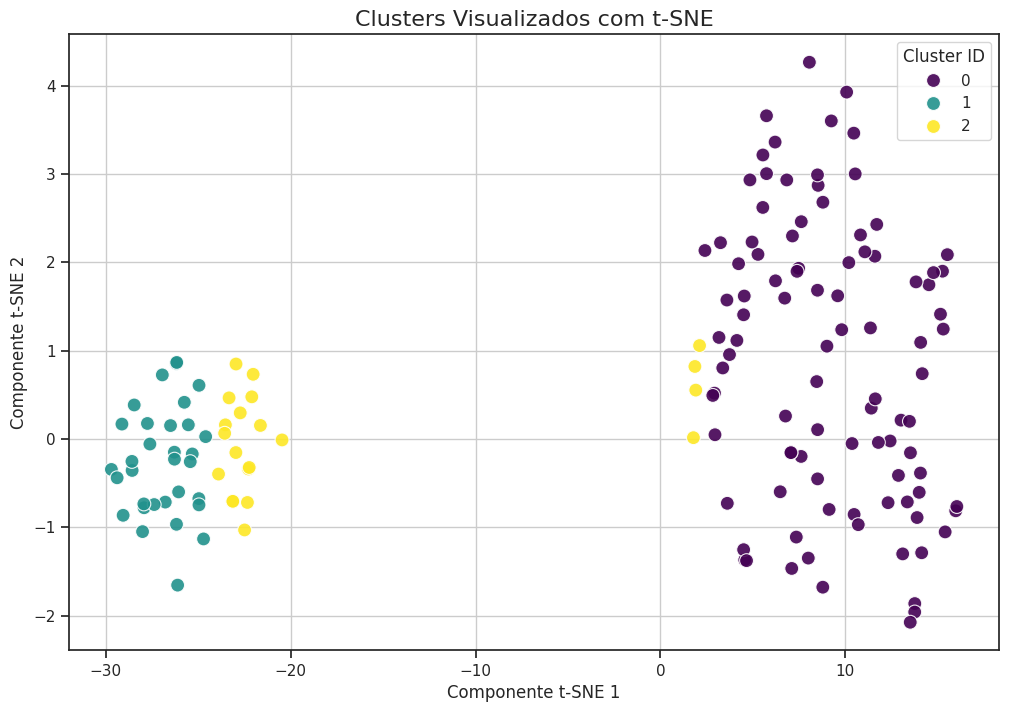

In [173]:
plotar_clusters_com_tsne(X_scaled, final_labels)

#### Para kmeans

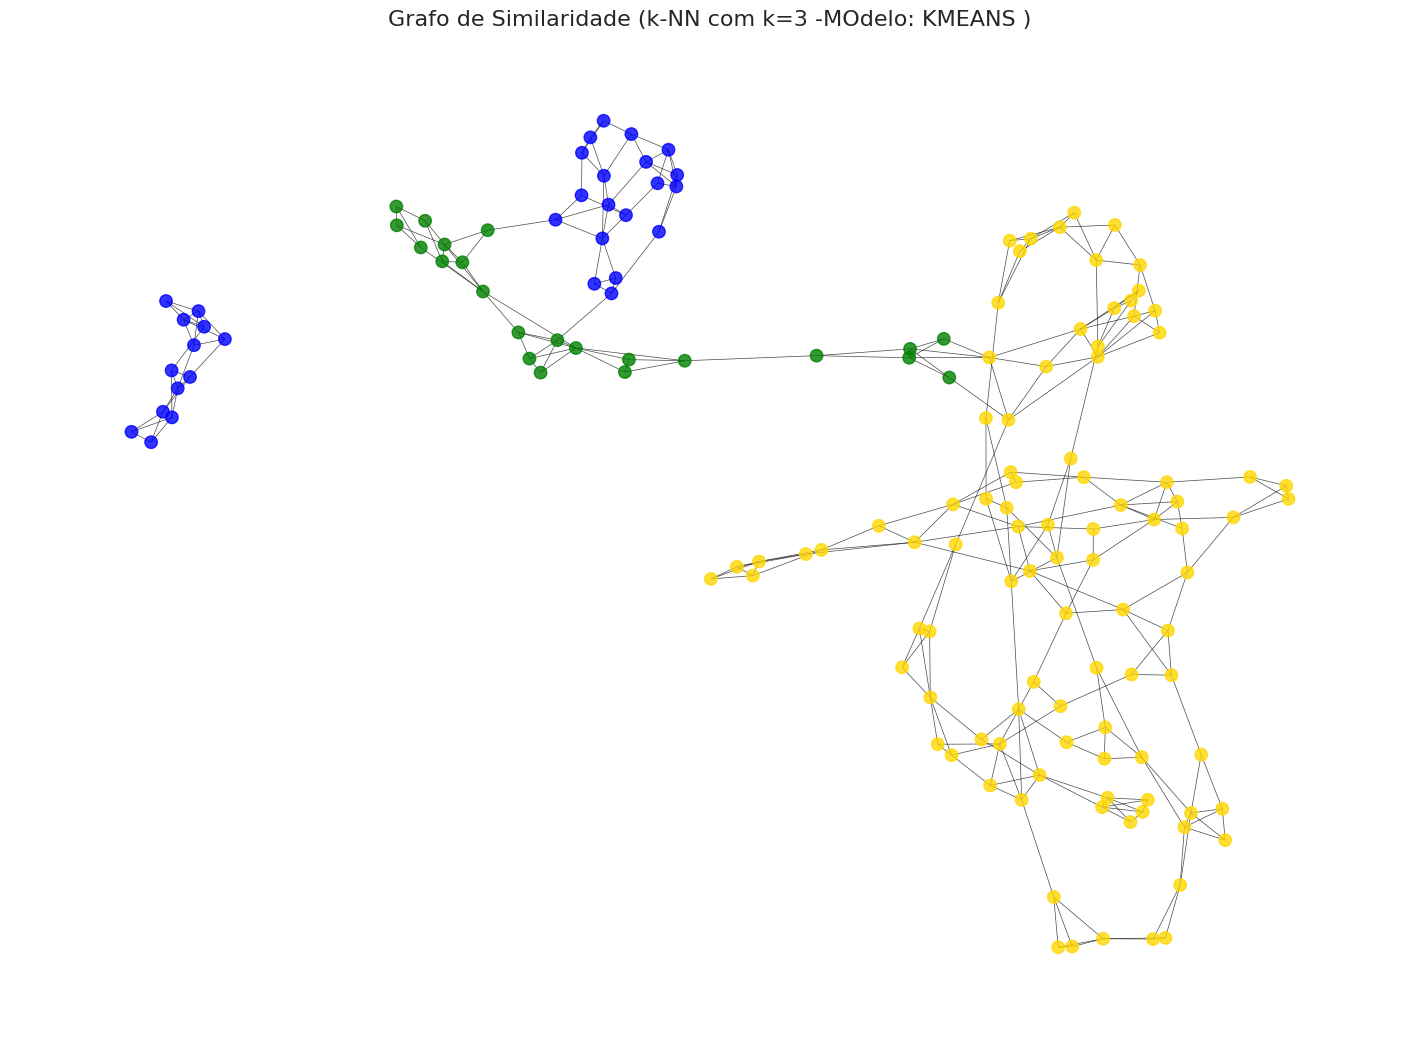

In [264]:
plotar_grafo_similaridade(X_scaled, final_labels, n_vizinhos=3,modelo="KMEANS")

#### para HCluster

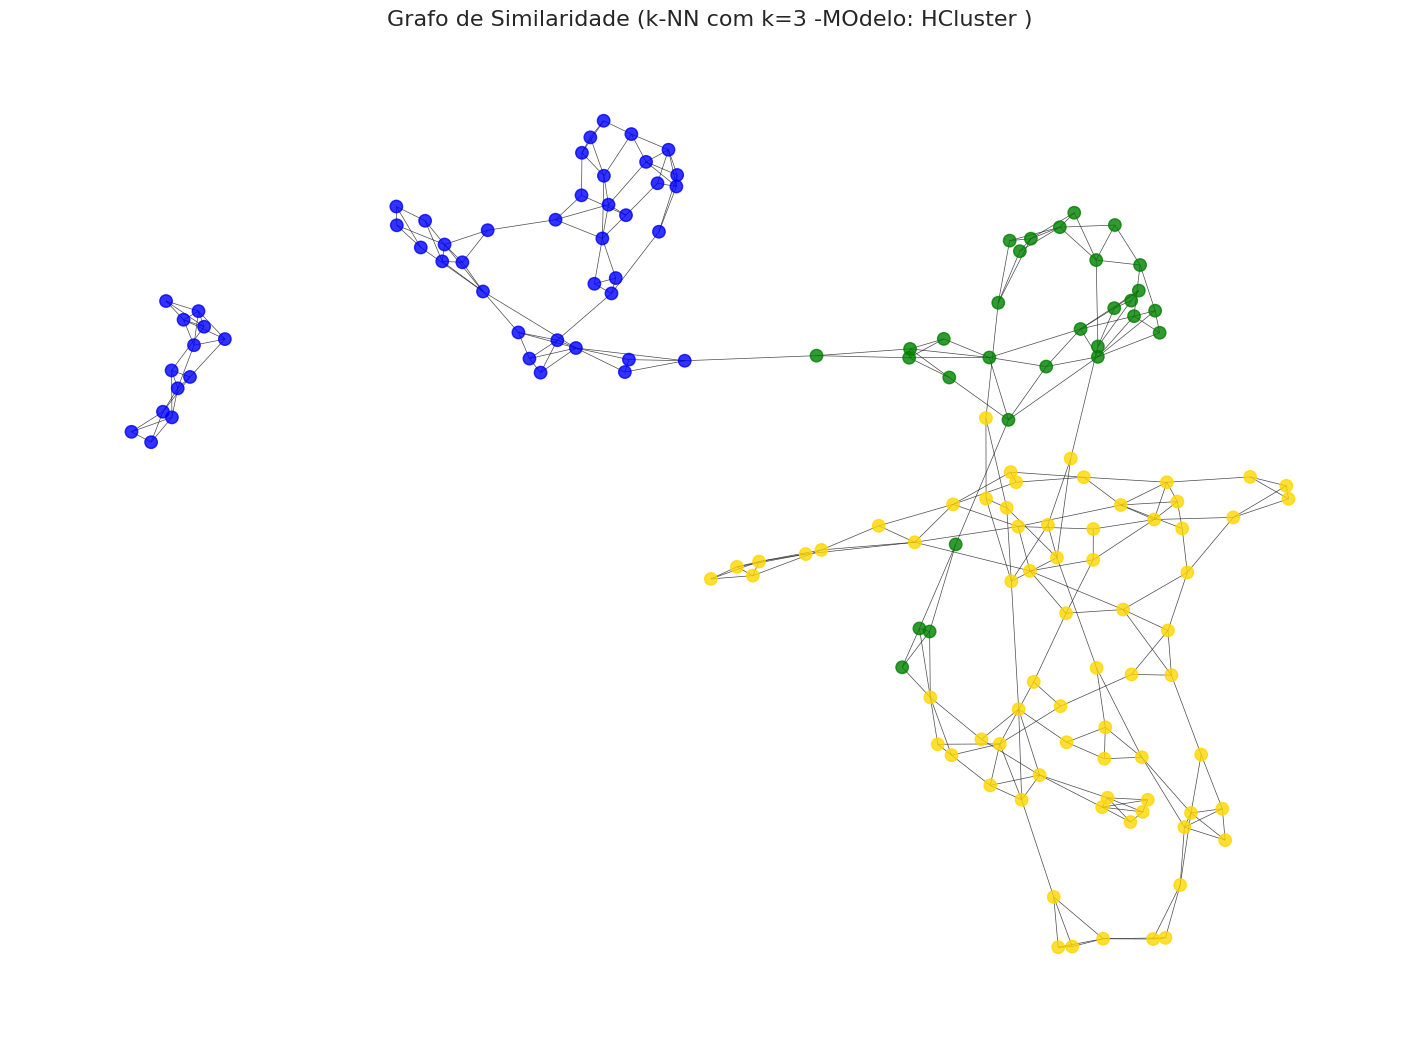

In [265]:
plotar_grafo_similaridade(X_scaled, final_labels_hc, n_vizinhos=3,modelo="HCluster")

### Dendrograma

In [266]:
def plotar_dendrograma(X_scaled, linkage_method='ward'):
    """
    Calcula a matriz de liga√ß√£o e plota o dendrograma para Agrupamento Hier√°rquico.

    Args:
        X_scaled (np.ndarray): Dados padronizados.
        linkage_method (str): M√©todo de liga√ß√£o a ser usado ('ward', 'complete', 'average', 'single').
    """
    # 1. Calcula a matriz de liga√ß√£o, que cont√©m a informa√ß√£o do agrupamento hier√°rquico
    linked = linkage(X_scaled, method=linkage_method)

    # 2. Plota o dendrograma
    plt.figure(figsize=(18, 9))
    dendrogram(
        linked,
        orientation='top',
        distance_sort='descending', # Ordena os galhos pela dist√¢ncia
        show_leaf_counts=True      # Mostra o n√∫mero de pontos em cada "folha" da √°rvore
    )
    plt.title(f'Dendrograma Hier√°rquico (Linkage: {linkage_method})', fontsize=16)
    plt.xlabel('√çndice da Amostra (ou tamanho do cluster)')
    plt.ylabel('Dist√¢ncia')
    plt.grid(axis='y')
    plt.show()


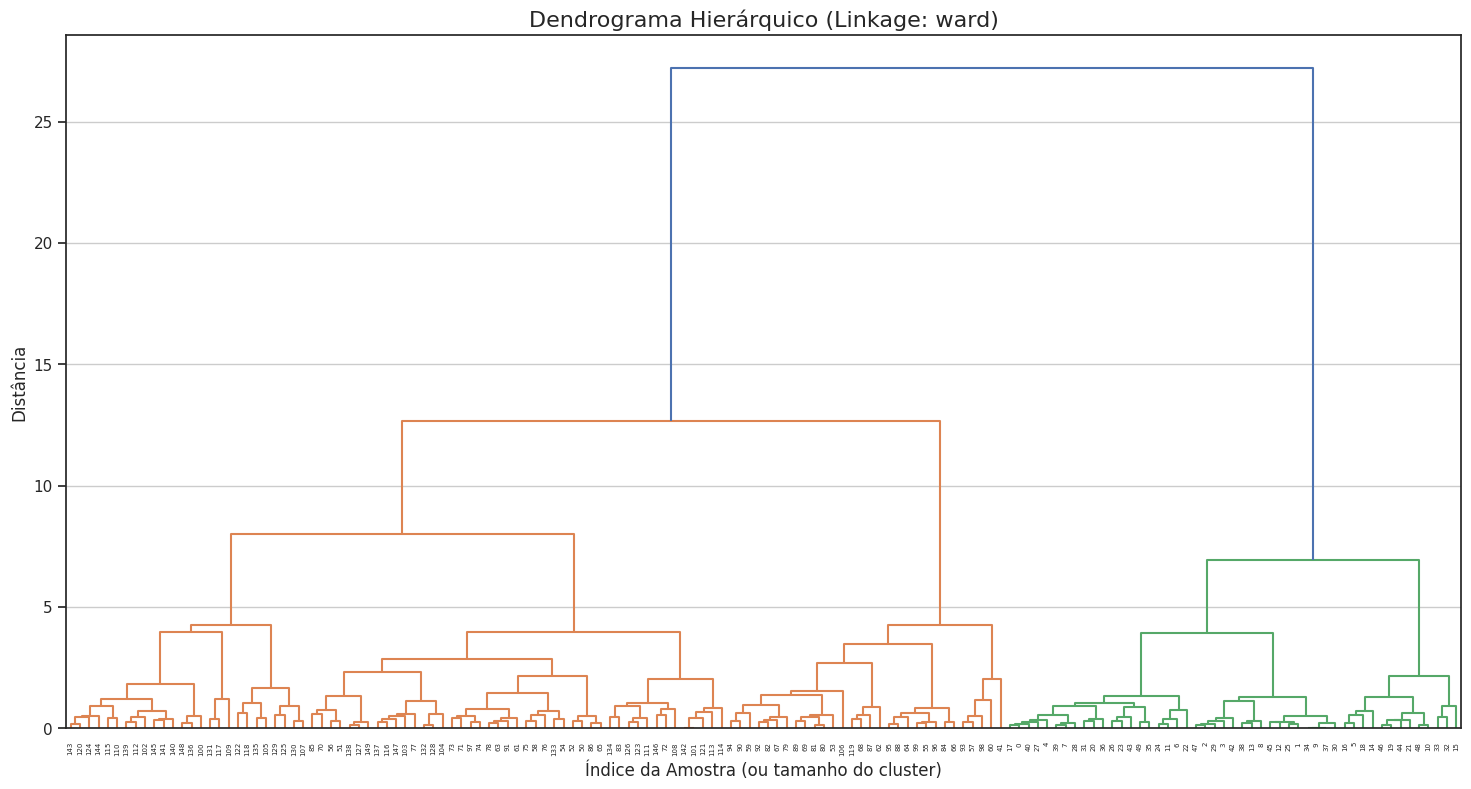

In [267]:
plotar_dendrograma(X_scaled, linkage_method='ward')